In [1]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from talib import WMA

idx = pd.IndexSlice
sns.set_style('whitegrid')

In [2]:
# Functions

# Cross-section
# Function	Definition
# rank(x)	Cross-sectional rank
# scale(x, a)	Rescaled x such that sum(abs(x)) = a (the default is a = 1)
# indneutralize(x, g)	x cross-sectionally demeaned within groups g (subindustries, industries, etc.)

def rank(df):
    return df.rank(axis=1, pct=True)


def scale(df):
    return df.div(df.abs().sum(axis=1), axis=0)

In [3]:
# Operators
# abs(x), log(x), sign(x), power(x, a) = standard definitions
# same for the operators “+”, “-”, “*”, “/”, “>”, “<”, “==”, “||”, “x ? y : z”
def log(df):
    return np.log1p(df)


def sign(df):
    return np.sign(df)


def power(df, exp):
    return df.pow(exp)

In [4]:
# Time Series
# Pandas Implementation

def ts_lag(df: pd.DataFrame, t: int = 1) -> pd.DataFrame:
    """Return the lagged values t periods ago.

    Args:
        :param df: tickers in columns, sorted dates in rows.
        :param t: lag

    Returns:
        pd.DataFrame: the lagged values
    """
    return df.shift(t)


def ts_delta(df, period=1):
    """
    Wrapper function to estimate difference.
    :param df: a pandas DataFrame.
    :param period: the difference grade.
    :return: a pandas DataFrame with today’s value minus the value 'period' days ago.
    """
    return df.diff(period)


def ts_sum(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    """Computes the rolling ts_sum for the given window size.

    Args:
        df (pd.DataFrame): tickers in columns, dates in rows.
        window      (int): size of rolling window.

    Returns:
        pd.DataFrame: the ts_sum over the last 'window' days.
    """
    return df.rolling(window).sum()


def ts_mean(df, window=10):
    """Computes the rolling mean for the given window size.

    Args:
        df (pd.DataFrame): tickers in columns, dates in rows.
        window      (int): size of rolling window.

    Returns:
        pd.DataFrame: the mean over the last 'window' days.
    """
    return df.rolling(window).mean()


def ts_weighted_mean(df, period=10):
    """
    Linear weighted moving average implementation.
    :param df: a pandas DataFrame.
    :param period: the LWMA period
    :return: a pandas DataFrame with the LWMA.
    """
    return (df.apply(lambda x: WMA(x, timeperiod=period)))


def ts_std(df, window=10):
    """
    Wrapper function to estimate rolling standard deviation.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return (df
            .rolling(window)
            .std())


def ts_rank(df, window=10):
    """
    Wrapper function to estimate rolling rank.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series rank over the past window days.
    """
    return (df
            .rolling(window)
            .apply(lambda x: x.rank().iloc[-1]))


def ts_product(df, window=10):
    """
    Wrapper function to estimate rolling ts_product.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series ts_product over the past 'window' days.
    """
    return (df
            .rolling(window)
            .apply(np.prod))


def ts_min(df, window=10):
    """
    Wrapper function to estimate rolling min.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return df.rolling(window).min()


def ts_max(df, window=10):
    """
    Wrapper function to estimate rolling min.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series max over the past 'window' days.
    """
    return df.rolling(window).max()


def ts_argmax(df, window=10):
    """
    Wrapper function to estimate which day ts_max(df, window) occurred on
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: well.. that :)
    """
    return df.rolling(window).apply(np.argmax).add(1)


def ts_argmin(df, window=10):
    """
    Wrapper function to estimate which day ts_min(df, window) occurred on
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: well.. that :)
    """
    return (df.rolling(window)
            .apply(np.argmin)
            .add(1))


def ts_corr(x, y, window=10):
    """
    Wrapper function to estimate rolling correlations.
    :param x, y: pandas DataFrames.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return x.rolling(window).corr(y)


def ts_cov(x, y, window=10):
    """
    Wrapper function to estimate rolling covariance.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return x.rolling(window).cov(y)

In [5]:
# 500 most-traded stocks data Load
ohlcv = ['open', 'high', 'low', 'close', 'volume']
data = (pd.read_hdf('data/data_alpha_factor.h5', 'data/top500').loc[:, ohlcv + ['ret_01', 'sector', 'ret_fwd']]
        .rename(columns={'ret_01': 'returns'}).sort_index())
adv20 = data.groupby('ticker').rolling(20).volume.mean().reset_index(0, drop=True)
data = data.assign(adv20=adv20)
data = data.join(data.groupby('date')[ohlcv].rank(axis=1, pct=True), rsuffix='_rank')
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1255093 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-29 00:00:00'))
Data columns (total 14 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   open         1255093 non-null  float64
 1   high         1255093 non-null  float64
 2   low          1255093 non-null  float64
 3   close        1255093 non-null  float64
 4   volume       1255093 non-null  float64
 5   returns      1254593 non-null  float64
 6   sector       1255093 non-null  float64
 7   ret_fwd      1255093 non-null  float64
 8   adv20        0 non-null        float64
 9   open_rank    1255093 non-null  float64
 10  high_rank    1255093 non-null  float64
 11  low_rank     1255093 non-null  float64
 12  close_rank   1255093 non-null  float64
 13  volume_rank  1255093 non-null  float64
dtypes: float64(14)
memory usage: 171.9+ MB


In [6]:
data.sample(10).sort_values(by='date')

open        high         low       close      volume  \
ticker date                                                                     
FOSL   2007-01-16   23.420000   23.520000   23.190000   23.390000    463600.0   
ENDP   2007-07-06   34.660000   34.950000   34.210000   34.580000    669400.0   
EL     2007-12-17   19.027617   19.049737   18.775449   18.925865   2906200.0   
CELG   2008-11-20   27.515000   27.975000   25.060000   25.520000  16394200.0   
AEE    2009-10-08   17.461937   17.524152   17.392808   17.455024   1155600.0   
MOS    2011-03-31   70.801267   71.303158   67.971639   68.144705   9012700.0   
DHI    2011-12-20   11.364610   11.837348   11.364610   11.752255  10422800.0   
DLR    2012-02-09   53.914447   53.952776   52.971538   52.986870   1690500.0   
MYL    2016-02-04   51.940000   53.210000   51.150000   52.310000   4032516.0   
BLK    2016-02-17  305.207401  307.528715  303.436501  306.202933    888075.0   

                    returns  sector   ret_fwd  adv20  open_rank  high_rank  \
ticker date                                                                  
FOSL   2007-01-16 -0.001281    11.0 -0.015819    NaN   0.370143   0.366053   
ENDP   2007-07-06 -0.002884     6.0  0.004049    NaN   0.536437   0.536437   
EL     2007-12-17 -0.012009    11.0  0.010285    NaN   0.215292   0.203219   
CELG   2008-11-20 -0.084648     6.0 -0.069357    NaN   0.798000   0.792000   
AEE    2009-10-08  0.001984     3.0  0.000792    NaN   0.282000   0.270000   
MOS    2011-03-31 -0.021131     5.0  0.020571    NaN   0.870000   0.870000   
DHI    2011-12-20  0.056973     4.0  0.028158    NaN   0.098000   0.098000   
DLR    2012-02-09 -0.015385     1.0 -0.005208    NaN   0.760000   0.754000   
MYL    2016-02-04  0.000957     6.0 -0.017587    NaN   0.536145   0.544177   
BLK    2016-02-17  0.017204     0.0 -0.012223    NaN   0.987952   0.987952   

                   low_rank  close_rank  volume_rank  
ticker date                                           
FOSL   2007-01-16  0.372188    0.372188     0.071575  
ENDP   2007-07-06  0.534413    0.532389     0.163968  
EL     2007-12-17  0.215292    0.209256     0.541247  
CELG   2008-11-20  0.798000    0.796000     0.798000  
AEE    2009-10-08  0.284000    0.278000     0.106000  
MOS    2011-03-31  0.864000    0.864000     0.850000  
DHI    2011-12-20  0.098000    0.098000     0.870000  
DLR    2012-02-09  0.754000    0.746000     0.296000  
MYL    2016-02-04  0.532129    0.538153     0.538153  
BLK    2016-02-17  0.987952    0.987952     0.052209

In [7]:
# Input Data
# returns: daily close-to-close returns
# open, close, high, low, volume: standard definitions for daily price and volume data
# vwap: daily volume-weighted average price
# cap: market cap
# adv{d}: average daily dollar volume for the past d days
# IndClass: a generic placeholder for a binary industry classification such as GICS, BICS, NAICS, SIC, etc., in indneutralize(x, IndClass.level), where level = sector, industry, subindustry, etc. Multiple IndClass in the same alpha need not correspond to the same industry classification.

o = data.open.unstack('ticker')
h = data.high.unstack('ticker')
l = data.low.unstack('ticker')
c = data.close.unstack('ticker')
v = data.volume.unstack('ticker')
vwap = o.add(h).add(l).add(c).div(4)
adv20 = v.rolling(20).mean()
r = data.returns.unstack('ticker')

In [8]:
# Evaluate Alphas
alphas = data[['returns', 'ret_fwd']].copy()
mi, ic = {}, {}


def get_mutual_info_score(returns, alpha, n=100000):
    df = pd.DataFrame({'y': returns, 'alpha': alpha}).dropna().sample(n=n)
    return mutual_info_regression(y=df.y, X=df[['alpha']])[0]

In [9]:
# Alpha 001 : rank(ts_argmax(power(((returns < 0) ? ts_std(returns, 20) : close), 2.), 5))
def alpha001(c, r):
    """(rank(ts_argmax(power(((returns < 0) ? ts_std(returns, 20) : close), 2.), 5)) -0.5)"""
    c[r < 0] = ts_std(r, 20)
    return (rank(ts_argmax(power(c, 2), 5)).mul(-.5).stack().swaplevel())

In [10]:
%%time
alpha = 1
alphas[f'{alpha:03}'] = alpha001(c, r)

CPU times: total: 2min 36s
Wall time: 2min 39s


In [11]:
alphas.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1255093 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-29 00:00:00'))
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   returns  1254593 non-null  float64
 1   ret_fwd  1255093 non-null  float64
 2   001      1243848 non-null  float64
dtypes: float64(3)
memory usage: 66.5+ MB


In [12]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')

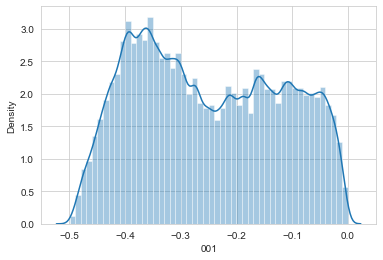

In [13]:
sns.distplot(alphas[f'{alpha:03}']);

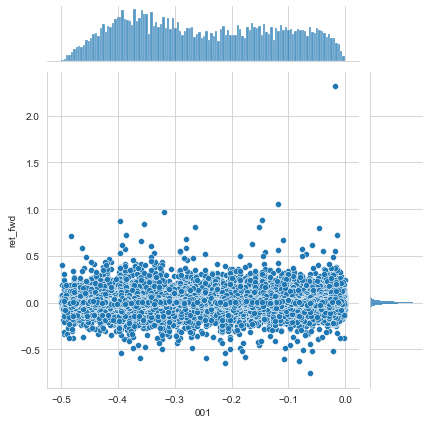

In [14]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas)

In [15]:
mi[1] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[1]

0.017305006105471143

In [16]:
# Alpha 002 : correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6))
def alpha002(o, c, v):
    """(-1 * ts_corr(rank(ts_delta(log(volume), 2)), rank(((close - open) / open)), 6))"""
    s1 = rank(ts_delta(log(v), 2))
    s2 = rank((c / o) - 1)
    alpha = -ts_corr(s1, s2, 6)
    return alpha.stack('ticker').swaplevel().replace([-np.inf, np.inf], np.nan)

In [17]:
%%time
alpha = 2
alphas[f'{alpha:03}'] = alpha002(o, c, v)

CPU times: total: 4.62 s
Wall time: 4.49 s


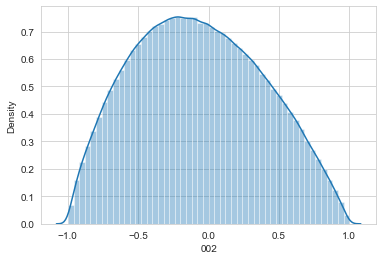

In [18]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

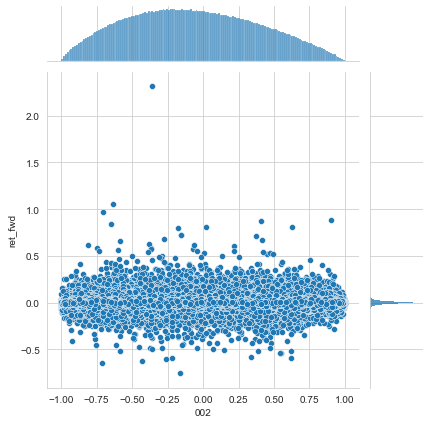

In [19]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas)

In [20]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[2]

0

In [21]:
# Alpha 003 : (-1 * correlation(rank(open), rank(volume), 10))
def alpha003(o, v):
    """(-1 * ts_corr(rank(open), rank(volume), 10))"""

    return (-ts_corr(rank(o), rank(v), 10).stack('ticker').swaplevel().replace([-np.inf, np.inf], np.nan))

In [22]:
%%time
alpha = 3
alphas[f'{alpha:03}'] = alpha003(o, v)

CPU times: total: 4.8 s
Wall time: 4.74 s


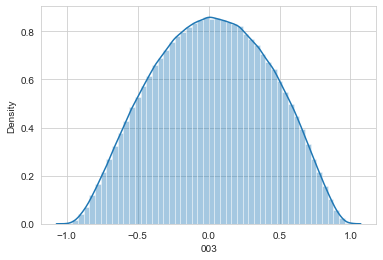

In [23]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}'].clip(lower=-1));

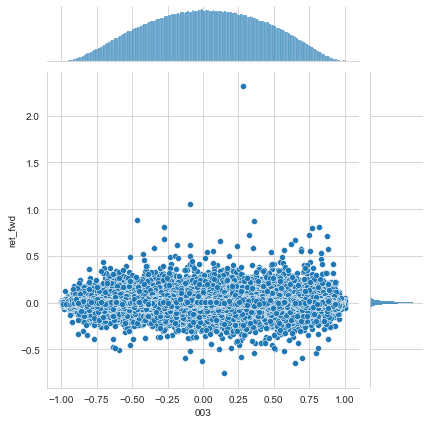

In [24]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [25]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.001086691849657484

In [26]:
# Alpha 004 = (-1 * Ts_Rank(rank(low), 9))
def alpha004(l):
    """(-1 * Ts_Rank(rank(low), 9))"""
    return (-ts_rank(rank(l), 9).stack('ticker').swaplevel())

In [27]:
%%time
alpha = 4
alphas[f'{alpha:03}'] = alpha004(l)

CPU times: total: 4min 8s
Wall time: 4min 10s


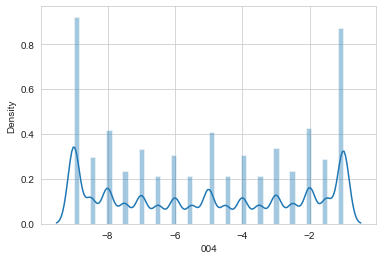

In [28]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

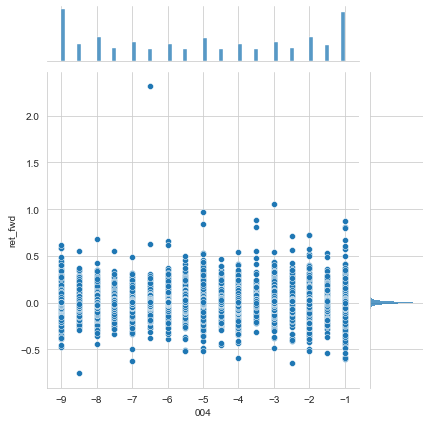

In [29]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [30]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0002201300346298396

In [31]:
# Alpha 005(Very roughly approximating wvap as average of OHLC) = (rank((open - (sum(vwap, 10) / 10))) * (-1 * abs(rank((close - vwap)))))
def alpha005(o, vwap, c):
    """(rank((open - ts_mean(vwap, 10))) * (-1 * abs(rank((close - vwap)))))"""
    return (rank(o.sub(ts_mean(vwap, 10))).mul(rank(c.sub(vwap)).mul(-1).abs()).stack('ticker').swaplevel())

In [32]:
%%time
alpha = 5
alphas[f'{alpha:03}'] = alpha005(o, vwap, c)

CPU times: total: 2.89 s
Wall time: 2.9 s


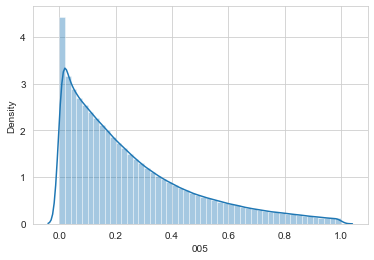

In [33]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

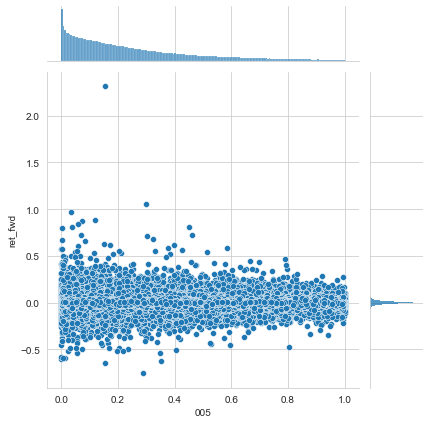

In [34]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [35]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.002266538906157578

In [36]:
# Alpha 006 = -ts_corr(open, volume, 10)
def alpha006(o, v):
    """(-ts_corr(open, volume, 10))"""
    return (-ts_corr(o, v, 10).stack('ticker').swaplevel())

In [37]:
%%time
alpha = 6
alphas[f'{alpha:03}'] = alpha006(o, v)

CPU times: total: 4.62 s
Wall time: 4.53 s


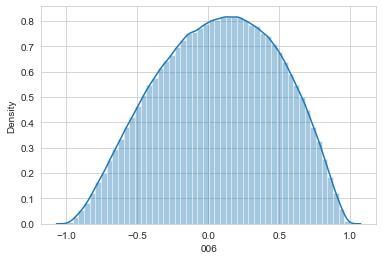

In [38]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

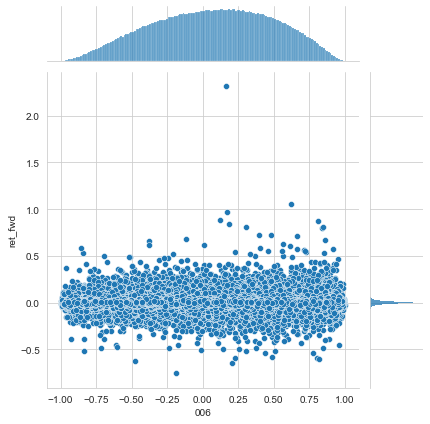

In [39]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [40]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.00458988417661832

In [41]:
# Alpha 007 = (adv20 < volume) ? ((-1 * ts_rank(abs(ts_delta(close, 7)), 60)) * sign(ts_delta(close, 7))) : -1
def alpha007(c, v, adv20):
    """(adv20 < volume) ? ((-ts_rank(abs(ts_delta(close, 7)), 60)) * sign(ts_delta(close, 7))) : -1 """

    delta7 = ts_delta(c, 7)
    return (-ts_rank(abs(delta7), 60).mul(sign(delta7)).where(adv20 < v, -1).stack('ticker').swaplevel())

In [42]:
%%time
alpha = 7
alphas[f'{alpha:03}'] = alpha007(c, v, adv20)

CPU times: total: 4min 9s
Wall time: 4min 13s


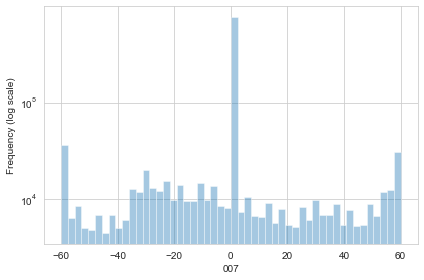

In [43]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
ax = sns.distplot(alphas[f'{alpha:03}'], kde=False)
ax.set_yscale('log')
ax.set_ylabel('Frequency (log scale)')
plt.tight_layout();

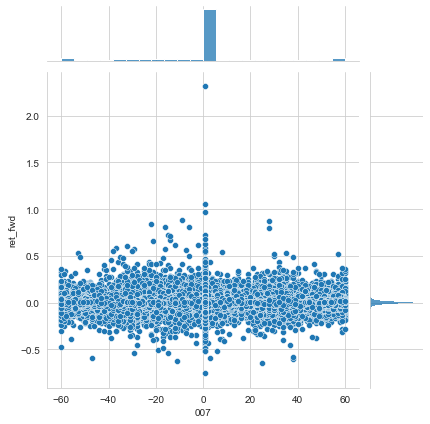

In [44]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [45]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.006798052965027335

In [46]:
# Alpha 008 = -rank(((ts_sum(open, 5) * ts_sum(returns, 5)) - ts_lag((ts_sum(open, 5) * ts_sum(returns, 5)),10)))
def alpha008(o, r):
    """-rank(((ts_sum(open, 5) * ts_sum(returns, 5)) - ts_lag((ts_sum(open, 5) * ts_sum(returns, 5)),10))) """
    return (-(rank(((ts_sum(o, 5) * ts_sum(r, 5)) - ts_lag((ts_sum(o, 5) * ts_sum(r, 5)), 10))))
            .stack('ticker').swaplevel())

In [47]:
%%time
alpha = 8
alphas[f'{alpha:03}'] = alpha008(o, r)

CPU times: total: 3.41 s
Wall time: 3.34 s


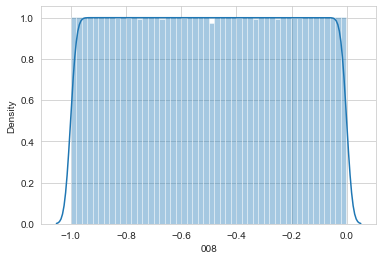

In [48]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

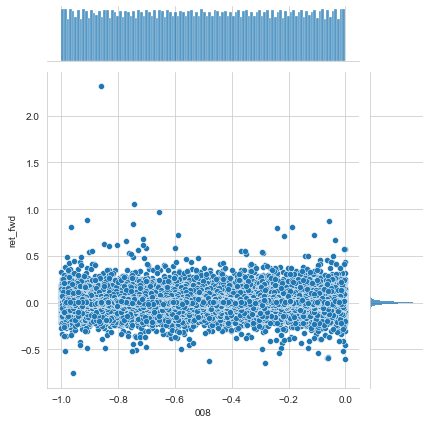

In [49]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [50]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.004016296804720376

In [51]:
# Alpha 009 = (0 < ts_min(ts_delta(close, 1), 5)) ? ts_delta(close, 1) : ((ts_max(ts_delta(close, 1), 5) < 0) ? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))

def alpha009(c):
    """(0 < ts_min(ts_delta(close, 1), 5)) ? ts_delta(close, 1) : ((ts_max(ts_delta(close, 1), 5) < 0)
    ? ts_delta(close, 1) : (-1 * ts_delta(close, 1))) """
    close_diff = ts_delta(c, 1)
    alpha = close_diff.where(ts_min(close_diff, 5) > 0, close_diff.where(ts_max(close_diff, 5) < 0,
                                              -close_diff))
    return (alpha.stack('ticker').swaplevel())

In [52]:
%%time
alpha = 9
alphas[f'{alpha:03}'] = alpha009(c)

CPU times: total: 3.23 s
Wall time: 3.29 s


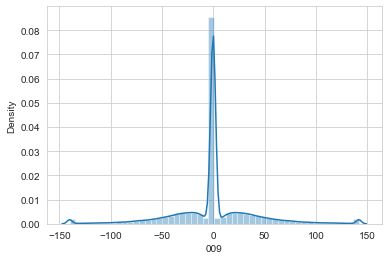

In [53]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
q = 0.01
sns.distplot(alphas[f'{alpha:03}'].clip(lower=alphas[f'{alpha:03}'].quantile(q),
                                        upper=alphas[f'{alpha:03}'].quantile(1 - q)));

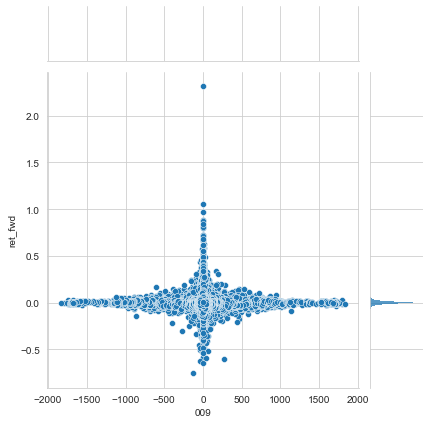

In [54]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [55]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.019296973496175873

In [56]:
pd.Series(mi)

1    0.017305
2    0.000000
3    0.001087
4    0.000220
5    0.002267
6    0.004590
7    0.006798
8    0.004016
9    0.019297
dtype: float64

In [57]:
# Alpha 010 = rank(((0 < ts_min(ts_delta(close, 1), 4)) ? ts_delta(close, 1) : ((ts_max(ts_delta(close, 1), 4) < 0) ? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))))
def alpha010(c):
    """rank(((0 < ts_min(ts_delta(close, 1), 4)) ? ts_delta(close, 1)
        : ((ts_max(ts_delta(close, 1), 4) < 0) ? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))))
    """
    close_diff = ts_delta(c, 1)
    alpha = close_diff.where(ts_min(close_diff, 4) > 0,
                             close_diff.where(ts_min(close_diff, 4) > 0, -close_diff))

    return (rank(alpha).stack('ticker').swaplevel())

In [58]:
%%time
alpha = 10
alphas[f'{alpha:03}'] = alpha010(c)

CPU times: total: 2.53 s
Wall time: 2.42 s


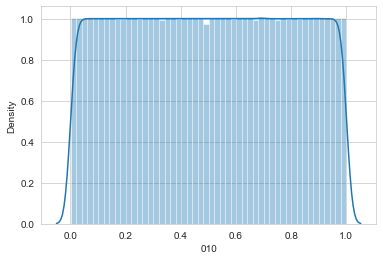

In [59]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

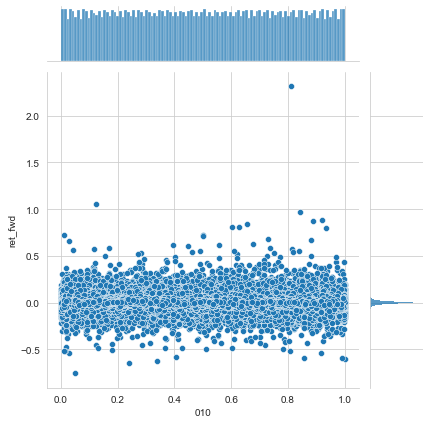

In [60]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [61]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0034614642089429992

In [62]:
pd.Series(mi).to_csv('mi.csv')

In [63]:
# Alpha 011 = ((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) *rank(ts_delta(volume, 3)))
def alpha011(c, vwap, v):
    """(rank(ts_max((vwap - close), 3)) + rank(ts_min(vwap - close), 3)) * rank(ts_delta(volume, 3)) """
    return (rank(ts_max(vwap.sub(c), 3)).add(rank(ts_min(vwap.sub(c), 3))).mul(rank(ts_delta(v, 3)))
            .stack('ticker').swaplevel())

In [64]:
%%time
alpha = 11
alphas[f'{alpha:03}'] = alpha011(c, vwap, v)

CPU times: total: 2.44 s
Wall time: 2.44 s


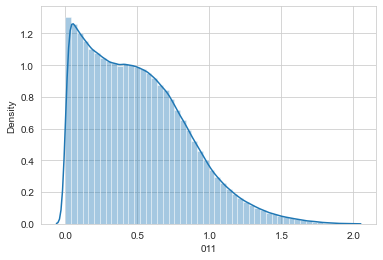

In [65]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

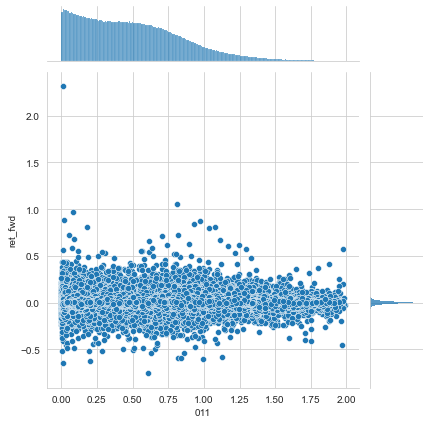

In [66]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [67]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0038350466649719195

In [68]:
# Alpha 012 =sign(ts_delta(volume, 1)) * -ts_delta(close, 1)
def alpha012(v, c):
    """(sign(ts_delta(volume, 1)) * (-1 * ts_delta(close, 1))) """
    return (sign(ts_delta(v, 1)).mul(-ts_delta(c, 1)).stack('ticker').swaplevel())

In [69]:
%%time
alpha = 12
alphas[f'{alpha:03}'] = alpha012(v, c)

CPU times: total: 2.22 s
Wall time: 2.22 s


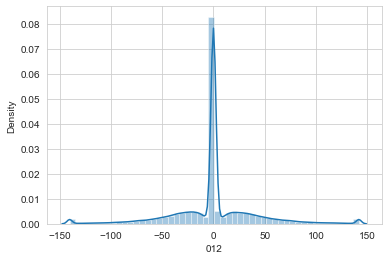

In [70]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
q = 0.01
sns.distplot(alphas[f'{alpha:03}'].clip(lower=alphas[f'{alpha:03}'].quantile(q),
                                        upper=alphas[f'{alpha:03}'].quantile(1 - q)));

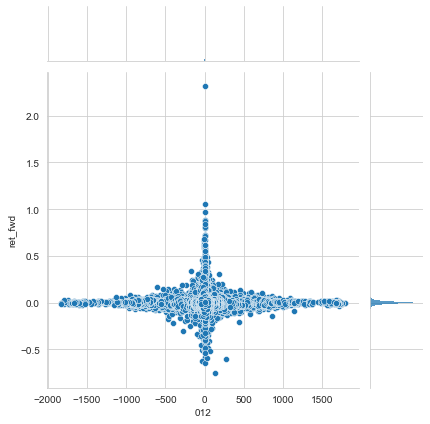

In [71]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [72]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.017448741735826445

In [73]:
# Alpha 013 = -rank(ts_cov(rank(close), rank(volume), 5))
def alpha013(c, v):
    """-rank(ts_cov(rank(close), rank(volume), 5))"""
    return (-rank(ts_cov(rank(c), rank(v), 5)).stack('ticker').swaplevel())

In [74]:
%%time
alpha = 13
alphas[f'{alpha:03}'] = alpha013(c, v)

CPU times: total: 4.75 s
Wall time: 4.68 s


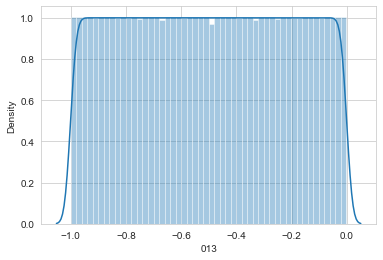

In [75]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

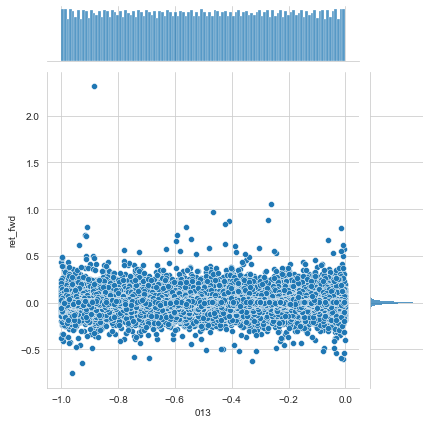

In [76]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [77]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.000492219045118425

In [78]:
pd.Series(mi).to_csv('mi.csv')

In [79]:
# Alpha 014 =(-rank(ts_delta(returns, 3))) * ts_corr(open, volume, 10))
def alpha014(o, v, r):
    """ (-rank(ts_delta(returns, 3))) * ts_corr(open, volume, 10)) """
    alpha = -rank(ts_delta(r, 3)).mul(ts_corr(o, v, 10).replace([-np.inf, np.inf], np.nan))
    return (alpha.stack('ticker').swaplevel())

In [80]:
%%time
alpha = 14
alphas[f'{alpha:03}'] = alpha014(o, v, r)

CPU times: total: 5.72 s
Wall time: 5.81 s


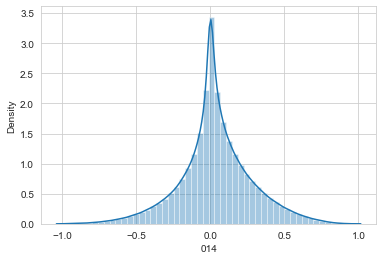

In [81]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

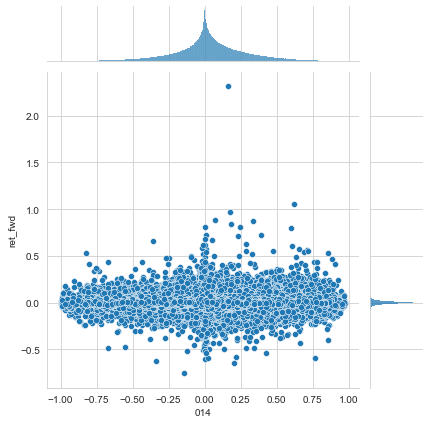

In [82]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [83]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.004085111046807199

In [84]:
# Alpha 015 = (-1 * ts_sum(rank(ts_corr(rank(high), rank(volume), 3)), 3))
def alpha015(h, v):
    """(-1 * ts_sum(rank(ts_corr(rank(high), rank(volume), 3)), 3))"""
    alpha = (-ts_sum(rank(ts_corr(rank(h), rank(v), 3).replace([-np.inf, np.inf], np.nan)), 3))
    return (alpha.stack('ticker').swaplevel())

In [85]:
%%time
alpha = 15
alphas[f'{alpha:03}'] = alpha015(h, v)

CPU times: total: 5.36 s
Wall time: 5.31 s


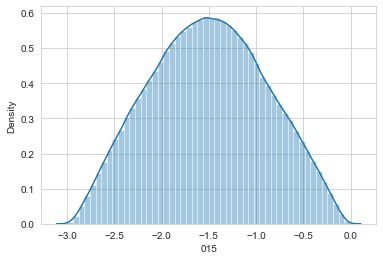

In [86]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

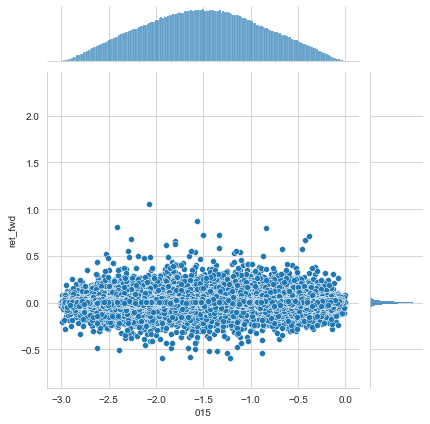

In [87]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [88]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [89]:
# Alpha 016 = (-1 * rank(ts_cov(rank(high), rank(volume), 5)))```
def alpha016(h, v):
    """(-1 * rank(ts_cov(rank(high), rank(volume), 5)))"""
    return (-rank(ts_cov(rank(h), rank(v), 5)).stack('ticker').swaplevel())

In [90]:
%%time
alpha = 16
alphas[f'{alpha:03}'] = alpha016(h, v)

CPU times: total: 3.7 s
Wall time: 3.67 s


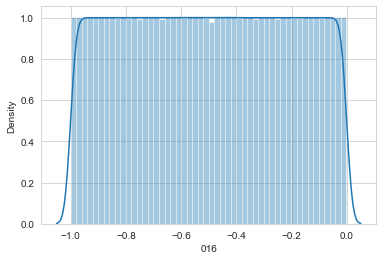

In [91]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

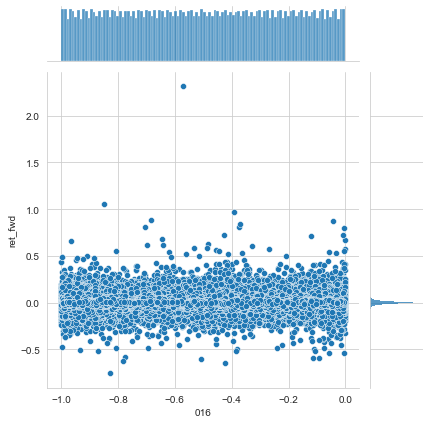

In [92]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [93]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.002027689356283169

In [94]:
pd.Series(mi).to_csv('mi.csv')

In [95]:
# Alpha 017 = rank(((0 < ts_min(ts_delta(close, 1), 4)) ? ts_delta(close, 1) : ((ts_max(ts_delta(close, 1), 4) < 0) ? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))))
def alpha017(c, v):
    """(((-1 * rank(ts_rank(close, 10))) * rank(ts_delta(ts_delta(close, 1), 1))) *rank(ts_rank((volume / adv20), 5))) """
    adv20 = ts_mean(v, 20)
    return (-rank(ts_rank(c, 10)).mul(rank(ts_delta(ts_delta(c, 1), 1))).mul(rank(ts_rank(v.div(adv20), 5)))
            .stack('ticker').swaplevel())

In [96]:
%%time
alpha = 17
alphas[f'{alpha:03}'] = alpha017(c, v)

CPU times: total: 8min 42s
Wall time: 8min 52s


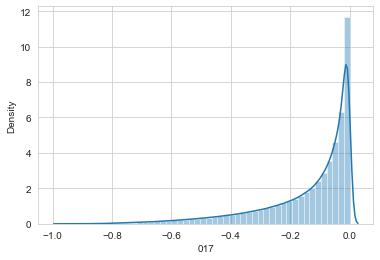

In [97]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

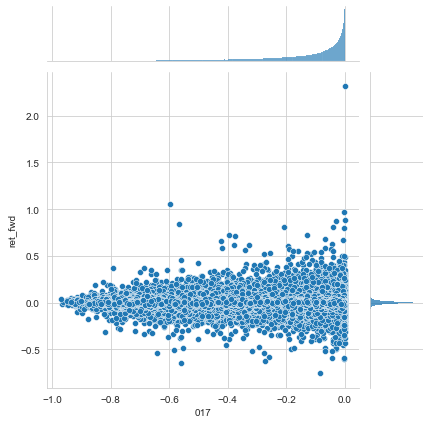

In [98]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [99]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.003022160608623814

In [100]:
# Alpha 018 = -rank((ts_std(abs((close - open)), 5) + (close - open)) + ts_corr(close, open,10))
def alpha018(o, c):
    """ -rank((ts_std(abs((close - open)), 5) + (close - open)) + ts_corr(close, open,10)) """
    return (-rank(ts_std(c.sub(o).abs(), 5).add(c.sub(o)).add(ts_corr(c, o, 10)
                       .replace([-np.inf, np.inf], np.nan))) .stack('ticker') .swaplevel())

In [101]:
%%time
alpha = 18
alphas[f'{alpha:03}'] = alpha018(o, c)

CPU times: total: 4.36 s
Wall time: 4.32 s


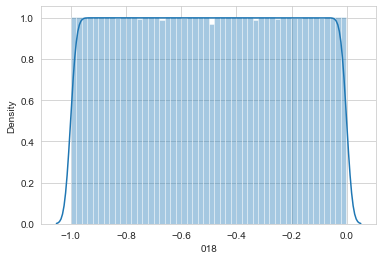

In [102]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

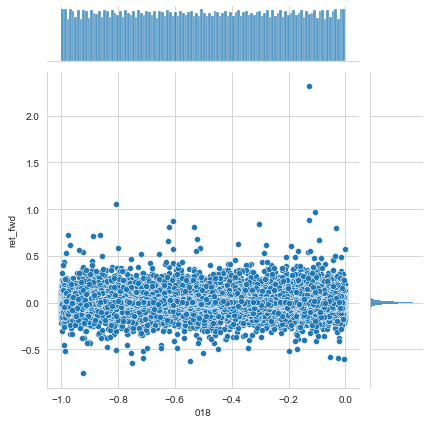

In [103]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [104]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0013246280013081702

In [105]:
# Alpha 019 = rank(((0 < ts_min(ts_delta(close, 1), 4)) ? ts_delta(close, 1) : ((ts_max(ts_delta(close, 1), 4) < 0) ? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))))
def alpha019(c, r):
    """ ((-1 * sign(((close - ts_lag(close, 7)) + ts_delta(close, 7)))) *
    (1 + rank((1 + ts_sum(returns,250))))) """
    return (-sign(ts_delta(c, 7) + ts_delta(c, 7)).mul(1 + rank(1 + ts_sum(r, 250))).stack('ticker')
            .swaplevel())

In [106]:
%%time
alpha = 19
alphas[f'{alpha:03}'] = alpha019(c, r)

CPU times: total: 3.2 s
Wall time: 3.23 s


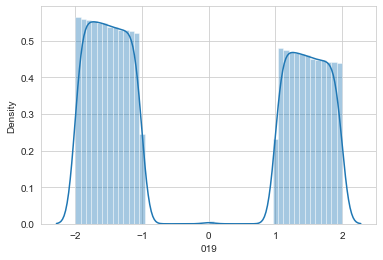

In [107]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

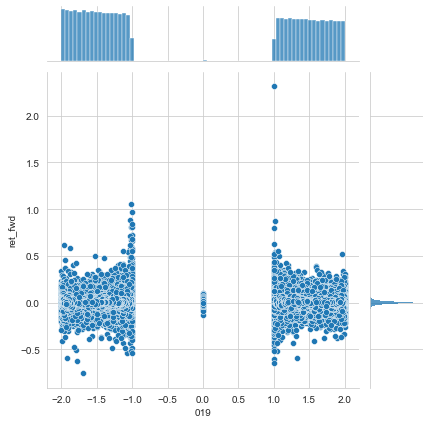

In [108]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [109]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.012406326197908157

In [110]:
pd.Series(mi).to_csv('mi.csv')

In [111]:
# Alpha 020 = -rank(open - ts_lag(high, 1)) * rank(open - ts_lag(close, 1)) * rank(open -ts_lag(low, 1))
def alpha020(o, h, l, c):
    """-rank(open - ts_lag(high, 1)) * rank(open - ts_lag(close, 1)) * rank(open -ts_lag(low, 1))"""
    return (rank(o - ts_lag(h, 1)).mul(rank(o - ts_lag(c, 1))).mul(rank(o - ts_lag(l, 1))).mul(-1)
            .stack('ticker').swaplevel())

In [112]:
%%time
alpha = 20
alphas[f'{alpha:03}'] = alpha020(o, h, l, c)

CPU times: total: 3.14 s
Wall time: 3.18 s


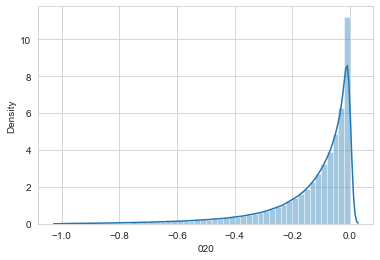

In [113]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

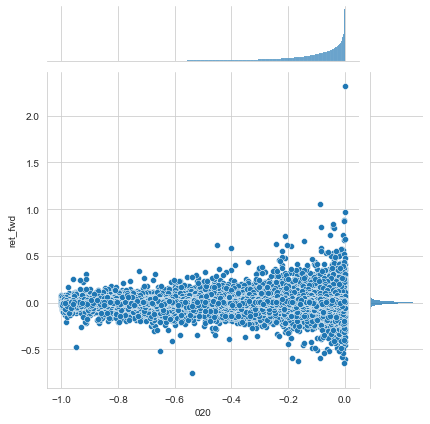

In [114]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [115]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [116]:
# Alpha 021 = ts_mean(close, 8) + ts_std(close, 8) < ts_mean(close, 2) ? -1 : (ts_mean(close,2) < ts_mean(close, 8) - ts_std(close, 8) ? 1 : (volume / adv20 < 1 ? -1 : 1))
def alpha021(c, v):
    """ ts_mean(close, 8) + ts_std(close, 8) < ts_mean(close, 2) ? -1
        : (ts_mean(close,2) < ts_mean(close, 8) - ts_std(close, 8) ? 1 : (volume / adv20 < 1 ? -1 : 1)) """
    sma2 = ts_mean(c, 2)
    sma8 = ts_mean(c, 8)
    std8 = ts_std(c, 8)

    cond_1 = sma8.add(std8) < sma2
    cond_2 = sma8.add(std8) > sma2
    cond_3 = v.div(ts_mean(v, 20)) < 1

    val = np.ones_like(c)
    alpha = pd.DataFrame(np.select(condlist=[cond_1, cond_2, cond_3], choicelist=[-1, 1, -1], default=1),
                         index=c.index, columns=c.columns)

    return (alpha.stack('ticker').swaplevel())

In [117]:
%%time
alpha = 21
alphas[f'{alpha:03}'] = alpha021(c, v)

CPU times: total: 3.36 s
Wall time: 3.43 s


In [118]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
alphas[f'{alpha:03}'].value_counts()

 1    1211187
-1      43906
Name: 021, dtype: int64

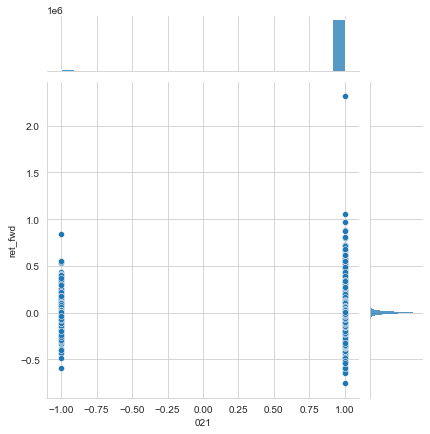

In [119]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [120]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [121]:
# Alpha 022 =  -(ts_delta(ts_corr(high, volume, 5), 5) * rank(ts_std(close, 20)))
def alpha022(h, c, v):
    """ -(ts_delta(ts_corr(high, volume, 5), 5) * rank(ts_std(close, 20))) """
    return (ts_delta(ts_corr(h, v, 5).replace([-np.inf, np.inf], np.nan), 5).mul(rank(ts_std(c, 20)))
            .mul(-1).stack('ticker').swaplevel())

In [122]:
%%time
alpha = 22
alphas[f'{alpha:03}'] = alpha022(h, c, v)

CPU times: total: 4.75 s
Wall time: 4.82 s


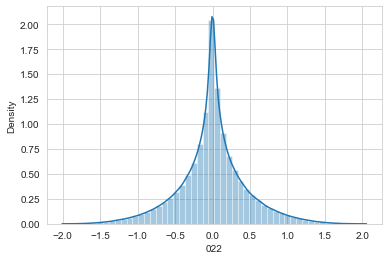

In [123]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

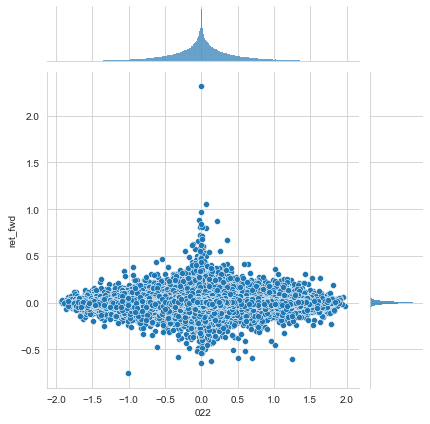

In [124]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [125]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0035162350228024053

In [126]:
pd.Series(mi).to_csv('mi.csv')

In [127]:
# Alpha 023 = ((ts_sum(high, 20) / 20) < high) ? (-1 * ts_delta(high, 2)) : 0
def alpha023(h, c):
    """((ts_mean(high, 20) < high) ? (-1 * ts_delta(high, 2)) : 0 """
    return (ts_delta(h, 2).mul(-1).where(ts_mean(h, 20) < h, 0).stack('ticker').swaplevel())

In [128]:
%%time
alpha = 23
alphas[f'{alpha:03}'] = alpha023(h, c)

CPU times: total: 3.14 s
Wall time: 3.21 s


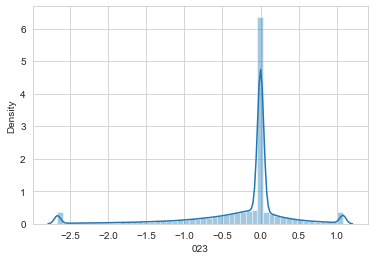

In [129]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
q = 0.025
sns.distplot(alphas[f'{alpha:03}'].clip(lower=alphas[f'{alpha:03}'].quantile(q),
                                        upper=alphas[f'{alpha:03}'].quantile(1 - q)));

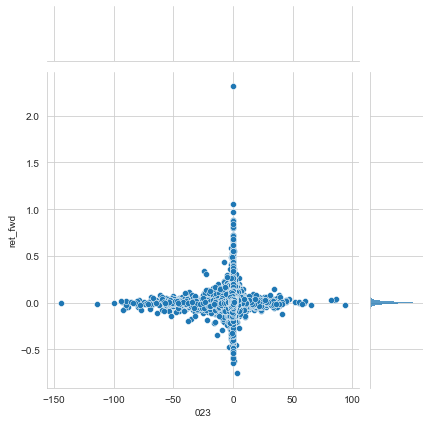

In [130]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [131]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.011110700755960323

In [132]:
# Alpha 024 = ((((ts_delta((ts_mean(close, 100)), 100) / ts_lag(close, 100)) <= 0.05) ? (-1 * (close - ts_min(close, 100)))  : (-1 * ts_delta(close, 3)))
def alpha024(c):
    """ ((((ts_delta((ts_mean(close, 100)), 100) / ts_lag(close, 100)) <= 0.05)
        ? (-1 * (close - ts_min(close, 100))) : (-1 * ts_delta(close, 3))) """
    cond = ts_delta(ts_mean(c, 100), 100) / ts_lag(c, 100) <= 0.05

    return (c.sub(ts_min(c, 100)).mul(-1).where(cond, -ts_delta(c, 3)).stack('ticker').swaplevel())

In [133]:
%%time
alpha = 24
alphas[f'{alpha:03}'] = alpha024(c)

CPU times: total: 3.61 s
Wall time: 3.54 s


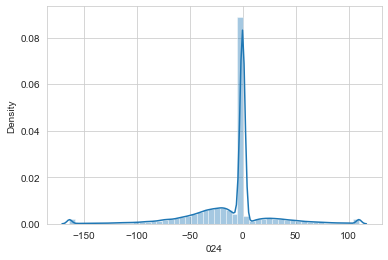

In [134]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
q = 0.01
sns.distplot(alphas[f'{alpha:03}'].clip(lower=alphas[f'{alpha:03}'].quantile(q),
                                        upper=alphas[f'{alpha:03}'].quantile(1 - q)));

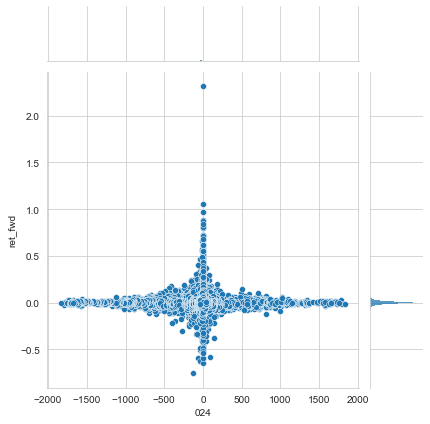

In [135]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [136]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.033464792723507664

In [137]:
# Alpha 025 = rank((-1 * returns) * adv20 * vwap * (high - close))
def alpha025(h, c, r, vwap, adv20):
    """rank((-1 * returns) * adv20 * vwap * (high - close))"""
    return (rank(-r.mul(adv20).mul(vwap).mul(h.sub(c))).stack('ticker').swaplevel())

In [138]:
%%time
alpha = 25
alphas[f'{alpha:03}'] = alpha025(h, c, r, vwap, adv20)

CPU times: total: 4.05 s
Wall time: 4.13 s


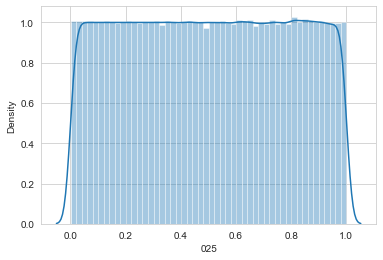

In [139]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

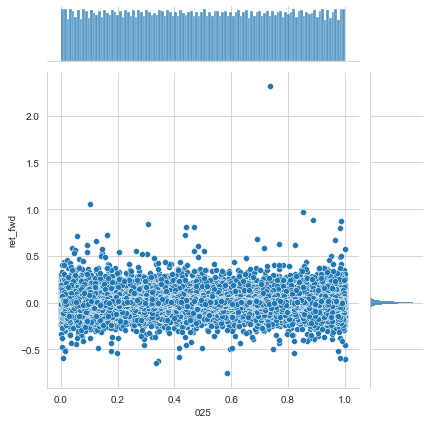

In [140]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [141]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.001447225795653928

In [142]:
pd.Series(mi).to_csv('mi.csv')

In [143]:
# Alpha 026 = (-1 * rank(ts_cov(rank(high), rank(volume), 5)))```
def alpha026(h, v):
    """(-1 * ts_max(ts_corr(ts_rank(volume, 5), ts_rank(high, 5), 5), 3))"""
    return (ts_max(ts_corr(ts_rank(v, 5), ts_rank(h, 5), 5) .replace([-np.inf, np.inf], np.nan), 3)
            .mul(-1).stack('ticker').swaplevel())

In [144]:
%%time
alpha = 26
alphas[f'{alpha:03}'] = alpha026(h, v)

CPU times: total: 8min 51s
Wall time: 9min 2s


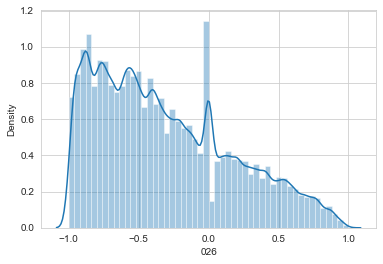

In [145]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

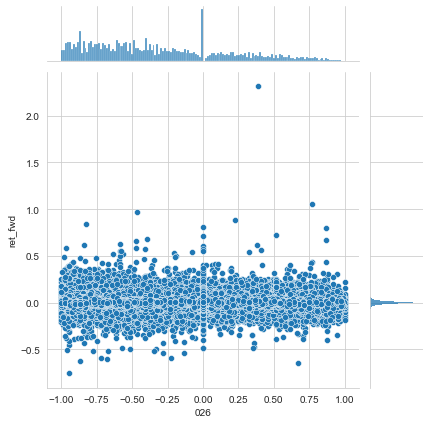

In [146]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [147]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.003461308114678374

In [148]:
# Alpha 027 =  rank(((0 < ts_min(ts_delta(close, 1), 4)) ? ts_delta(close, 1) : ((ts_max(ts_delta(close, 1), 4) < 0) ? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))))
def alpha027(v, vwap):
    """((0.5 < rank(ts_mean(ts_corr(rank(volume), rank(vwap), 6), 2))) ? -1 : 1)"""
    cond = rank(ts_mean(ts_corr(rank(v), rank(vwap), 6), 2))
    alpha = cond.notnull().astype(float)
    return (alpha.where(cond <= 0.5, -alpha).stack('ticker').swaplevel())

In [149]:
%%time
alpha = 27
alphas[f'{alpha:03}'] = alpha027(v, vwap)

CPU times: total: 3.98 s
Wall time: 3.91 s


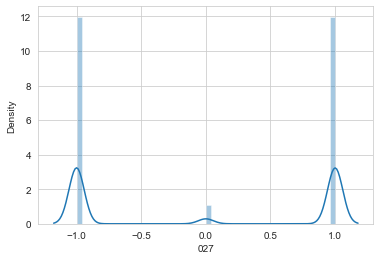

In [150]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

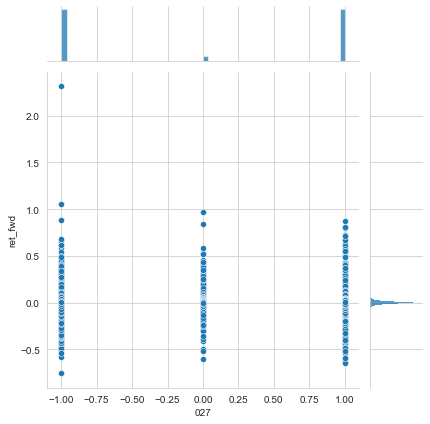

In [151]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [152]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0010891831398742724

In [153]:
# Alpha 028 = -rank((ts_std(abs((close - open)), 5) + (close - open)) + ts_corr(close, open,10))
def alpha028(h, l, c, v, adv20):
    """scale(((ts_corr(adv20, low, 5) + (high + low) / 2) - close))"""
    return (scale(ts_corr(adv20, l, 5).replace([-np.inf, np.inf], 0).add(h.add(l).div(2).sub(c)))
            .stack('ticker').swaplevel())

In [154]:
%%time
alpha = 28
alphas[f'{alpha:03}'] = alpha028(h, l, c, v, adv20)

CPU times: total: 4.17 s
Wall time: 4.06 s


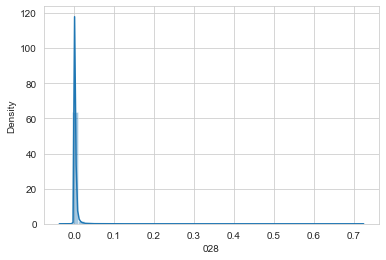

In [155]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

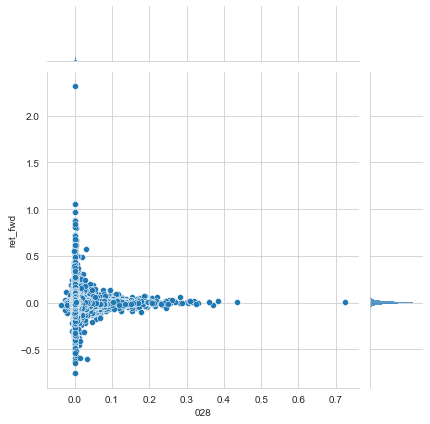

In [156]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [157]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.008341042451053049

In [158]:
pd.Series(mi).to_csv('mi.csv')

In [159]:
# Alpha 029 = rank(((0 < ts_min(ts_delta(close, 1), 4)) ? ts_delta(close, 1) : ((ts_max(ts_delta(close, 1), 4) < 0) ? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))))
def alpha029(c, r):
    """ (ts_min(ts_product(rank(rank(scale(log(ts_sum(ts_min(rank(rank((-1 *
            rank(ts_delta((close - 1),5))))), 2), 1))))), 1), 5) + ts_rank(ts_lag((-1 * returns), 6), 5)) """
    return (ts_min(rank(rank(scale(log(ts_sum(rank(rank(-rank(ts_delta((c - 1), 5)))), 2))))), 5)
            .add(ts_rank(ts_lag((-1 * r), 6), 5)).stack('ticker').swaplevel())

In [160]:
%%time
alpha = 29
alphas[f'{alpha:03}'] = alpha029(c, r)

CPU times: total: 3min 59s
Wall time: 4min 2s


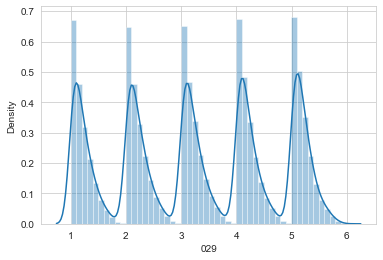

In [161]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

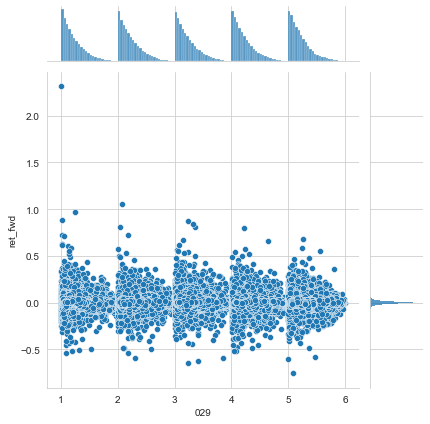

In [162]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [163]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0014891160314807195

In [164]:
# Alpha 030 =  -rank(open - ts_lag(high, 1)) * rank(open - ts_lag(close, 1)) * rank(open -ts_lag(low, 1))
def alpha030(c, v):
    """(((1.0 - rank(((sign((close - ts_lag(close, 1))) + sign((ts_lag(close, 1) - ts_lag(close, 2)))) +
            sign((ts_lag(close, 2) - ts_lag(close, 3)))))) * ts_sum(volume, 5)) / ts_sum(volume, 20))"""
    close_diff = ts_delta(c, 1)
    return (rank(sign(close_diff).add(sign(ts_lag(close_diff, 1))).add(sign(ts_lag(close_diff, 2))))
            .mul(-1).add(1).mul(ts_sum(v, 5)).div(ts_sum(v, 20)).stack('ticker').swaplevel())

In [165]:
%%time
alpha = 30
alphas[f'{alpha:03}'] = alpha030(c, v)

CPU times: total: 3.12 s
Wall time: 3.28 s


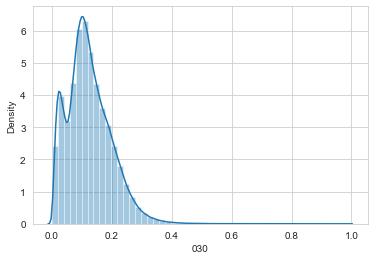

In [166]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

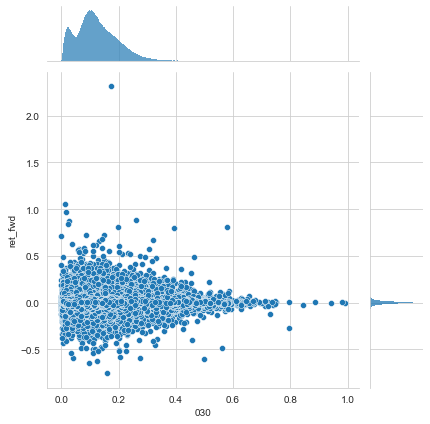

In [167]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [168]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.00052851429554579

In [169]:
# Alpha 031 =  ts_mean(close, 8) + ts_std(close, 8) < ts_mean(close, 2) ? -1 : (ts_mean(close,2) < ts_mean(close, 8) - ts_std(close, 8) ? 1 : (volume / adv20 < 1 ? -1 : 1))
def alpha031(l, c, adv20):
    """((rank(rank(rank(ts_weighted_mean((-1 * rank(rank(ts_delta(close, 10)))), 10)))) +
        rank((-1 * ts_delta(close, 3)))) + sign(scale(ts_corr(adv20, low, 12)))) """
    return (rank(rank(rank(ts_weighted_mean(rank(rank(ts_delta(c, 10))).mul(-1), 10))))
            .add(rank(ts_delta(c, 3).mul(-1))).add(sign(scale(ts_corr(adv20, l, 12)
            .replace([-np.inf, np.inf],np.nan)))).stack('ticker').swaplevel())

In [170]:
%%time
alpha = 31
alphas[f'{alpha:03}'] = alpha031(l, c, adv20)

CPU times: total: 4.66 s
Wall time: 4.96 s


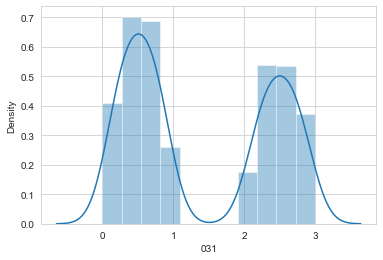

In [171]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

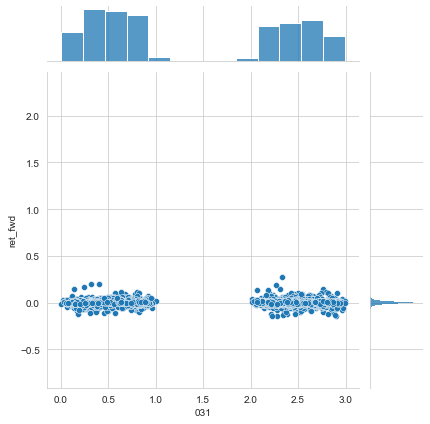

In [172]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [173]:
# Alpha 032 =  scale(ts_mean(close, 7) - close) + (20 * scale(ts_corr(vwap, ts_lag(close, 5),230)))
def alpha032(c, vwap):
    """scale(ts_mean(close, 7) - close) + (20 * scale(ts_corr(vwap, ts_lag(close, 5),230)))"""
    return (scale(ts_mean(c, 7).sub(c)).add(20 * scale(ts_corr(vwap,ts_lag(c, 5), 230)))
            .stack('ticker').swaplevel())

In [174]:
%%time
alpha = 32
alphas[f'{alpha:03}'] = alpha032(c, vwap)

CPU times: total: 3.66 s
Wall time: 3.7 s


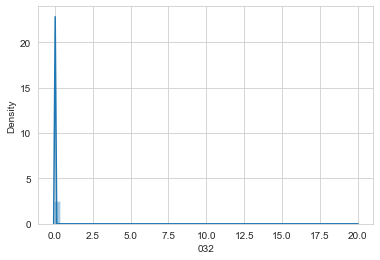

In [175]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

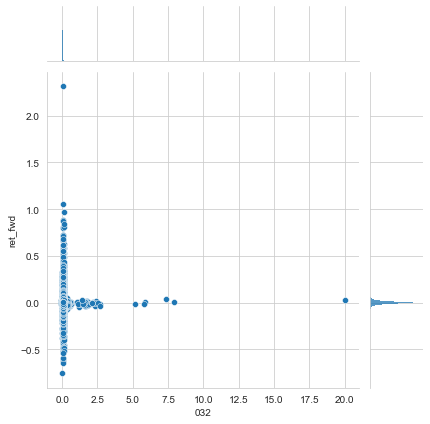

In [176]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [177]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.01697336423696072

In [178]:
# Alpha 033 = ((ts_sum(high, 20) / 20) < high) ? (-1 * ts_delta(high, 2)) : 0
def alpha033(o, c):
    """rank(-(1 - (open / close)))"""
    return (rank(o.div(c).mul(-1).add(1).mul(-1)).stack('ticker').swaplevel())

In [179]:
%%time
alpha = 33
alphas[f'{alpha:03}'] = alpha033(o, c)

CPU times: total: 4.05 s
Wall time: 4.01 s


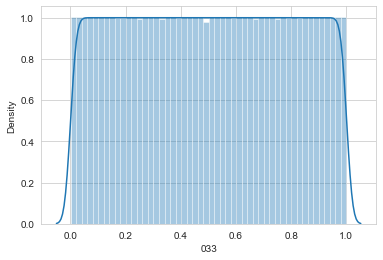

In [180]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

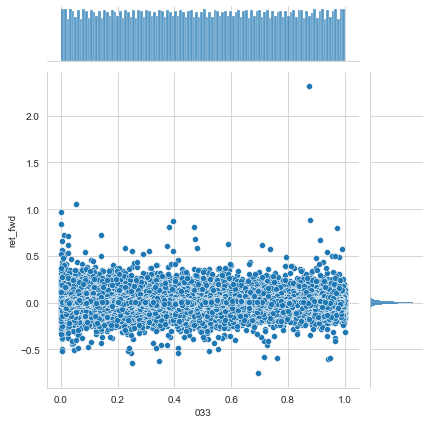

In [181]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [182]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0034463446202055437

In [183]:
# Alpha 034 = ((((ts_delta((ts_mean(close, 100)), 100) / ts_lag(close, 100)) <= 0.05) ? (-1 * (close - ts_min(close, 100))) : (-1 * ts_delta(close, 3)))
def alpha034(c, r):
    """rank(((1 - rank((ts_std(returns, 2) / ts_std(returns, 5)))) + (1 - rank(ts_delta(close, 1)))))"""
    return (rank(rank(ts_std(r, 2).div(ts_std(r, 5)).replace([-np.inf, np.inf],np.nan)).mul(-1)
                 .sub(rank(ts_delta(c, 1))).add(2)).stack('ticker').swaplevel())

In [184]:
%%time
alpha = 34
alphas[f'{alpha:03}'] = alpha034(c, r)

CPU times: total: 2.34 s
Wall time: 2.32 s


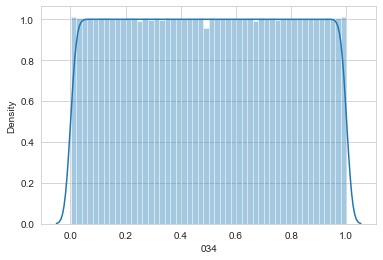

In [185]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

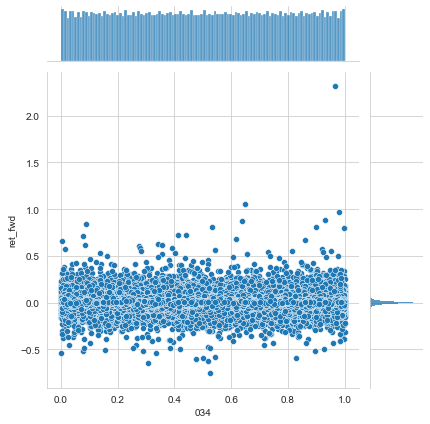

In [186]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [187]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [188]:
pd.Series(mi).to_csv('mi.csv')

In [189]:
# Alpha 035 = rank((-1 * returns) * adv20 * vwap * (high - close))
def alpha035(h, l, c, v, r):
    """((ts_Rank(volume, 32) * (1 - ts_Rank(((close + high) - low), 16))) * (1 -ts_Rank(returns, 32)))"""
    return (ts_rank(v, 32).mul(1 - ts_rank(c.add(h).sub(l), 16)).mul(1 - ts_rank(r, 32))
            .stack('ticker').swaplevel())

In [190]:
%%time
alpha = 35
alphas[f'{alpha:03}'] = alpha035(h, l, c, v, r)

CPU times: total: 12min 12s
Wall time: 12min 26s


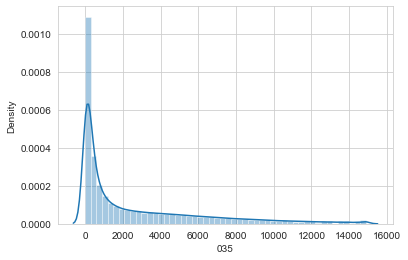

In [191]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

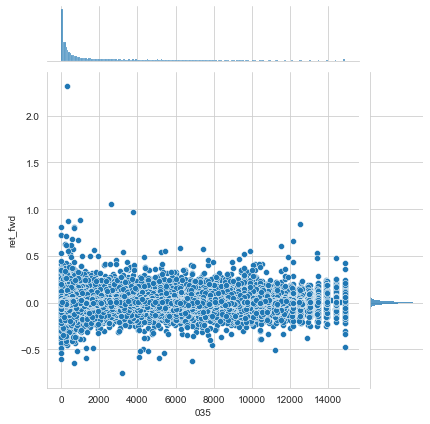

In [192]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [193]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0027014229533159906

In [194]:
# Alpha 036 = 2.21 * rank(ts_corr((close - open), ts_lag(volume, 1), 15)) + 0.7 * rank((open- close)) + 0.73 * rank(ts_Rank(ts_lag(-1 * returns, 6), 5)) + rank(abs(ts_corr(vwap,adv20, 6))) + 0.6 * rank(((ts_mean(close, 200) - open) * (close - open)))
def alpha036(o, c, v, r, adv20):
    """2.21 * rank(ts_corr((close - open), ts_lag(volume, 1), 15)) + 0.7 * rank((open- close)) +
        0.73 * rank(ts_Rank(ts_lag(-1 * returns, 6), 5)) + rank(abs(ts_corr(vwap,adv20, 6))) +
        0.6 * rank(((ts_mean(close, 200) - open) * (close - open))) """
    return (rank(ts_corr(c.sub(o), ts_lag(v, 1), 15)).mul(2.21).add(rank(o.sub(c)).mul(.7))
            .add(rank(ts_rank(ts_lag(-r, 6), 5)).mul(0.73)).add(rank(abs(ts_corr(vwap, adv20, 6))))
            .add(rank(ts_mean(c, 200).sub(o).mul(c.sub(o))).mul(0.6)).stack('ticker').swaplevel())

In [195]:
%%time
alpha = 36
alphas[f'{alpha:03}'] = alpha036(o, c, v, r, adv20)

CPU times: total: 3min 51s
Wall time: 3min 52s


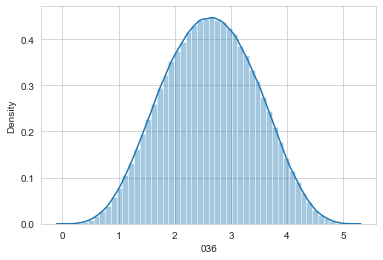

In [196]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

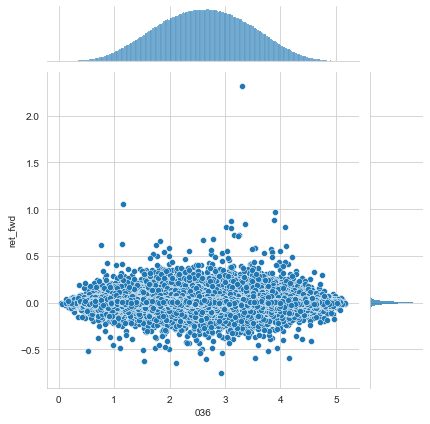

In [197]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [198]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [199]:
# Alpha 037 = rank(ts_corr(ts_lag(open - close, 1), close, 200)) + rank(open - close)
def alpha037(o, c):
    """(rank(ts_corr(ts_lag((open - close), 1), close, 200)) + rank((open - close)))"""
    return (rank(ts_corr(ts_lag(o.sub(c), 1), c, 200)).add(rank(o.sub(c))).stack('ticker').swaplevel())

In [200]:
%%time
alpha = 37
alphas[f'{alpha:03}'] = alpha037(o, c)

CPU times: total: 3.66 s
Wall time: 3.54 s


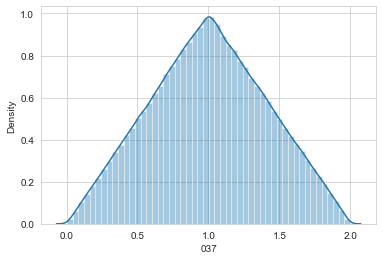

In [201]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

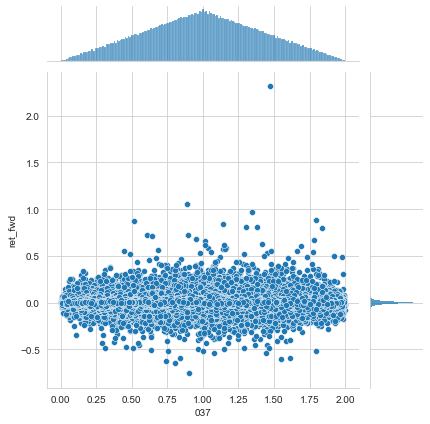

In [202]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [203]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [204]:
pd.Series(mi).to_csv('mi.csv')

In [205]:
# Alpha 038 = 1 * rank(ts_rank(close, 10)) * rank(close / open)
def alpha038(o, c):
    """"-1 * rank(ts_rank(close, 10)) * rank(close / open)"""
    return (rank(ts_rank(o, 10)).mul(rank(c.div(o).replace([-np.inf, np.inf], np.nan))).mul(-1)
            .stack('ticker').swaplevel())

In [206]:
%%time
alpha = 38
alphas[f'{alpha:03}'] = alpha038(o, c)

CPU times: total: 3min 52s
Wall time: 3min 53s


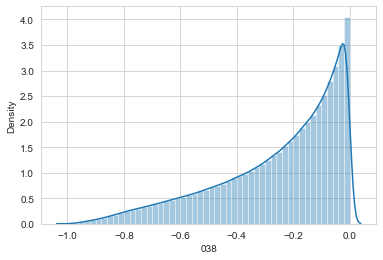

In [207]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

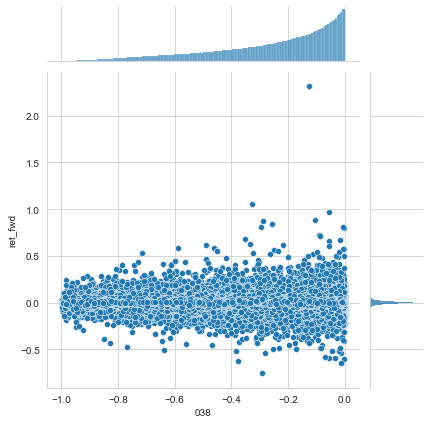

In [208]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [209]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0006117879483884536

In [210]:
# Alpha 039 = -rank(ts_delta(close, 7) * (1 - rank(ts_weighted_mean(volume / adv20, 9)))) * (1 + rank(ts_sum(returns, 250)))
def alpha039(c, v, r, adv20):
    """ -rank(ts_delta(close, 7) * (1 - rank(ts_weighted_mean(volume / adv20, 9)))) *
            (1 + rank(ts_sum(returns, 250))) """
    return (rank(ts_delta(c, 7).mul(rank(ts_weighted_mean(v.div(adv20), 9)).mul(-1).add(1))).mul(-1)
            .mul(rank(ts_mean(r, 250).add(1))).stack('ticker').swaplevel())

In [211]:
%%time
alpha = 39
alphas[f'{alpha:03}'] = alpha039(c, v, r, adv20)

CPU times: total: 3.16 s
Wall time: 2.83 s


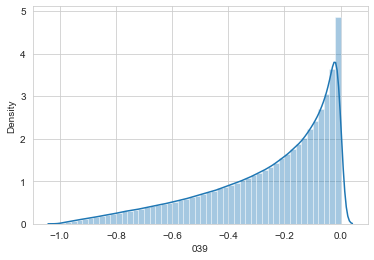

In [212]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

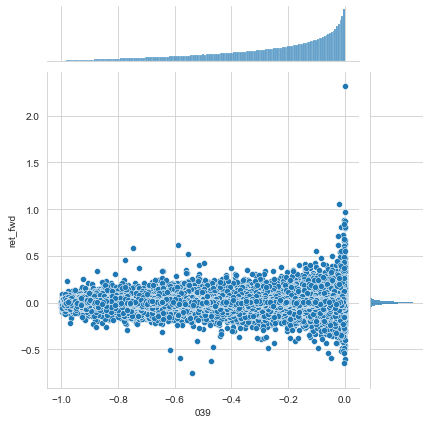

In [213]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [214]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0023325403857263893

In [215]:
# Alpha 040 = -rank(open - ts_lag(high, 1)) * rank(open - ts_lag(close, 1)) * rank(open -ts_lag(low, 1))
def alpha040(h, v):
    """((-1 * rank(ts_std(high, 10))) * ts_corr(high, volume, 10))"""
    return (rank(ts_std(h, 10)).mul(ts_corr(h, v, 10)).mul(-1).stack('ticker').swaplevel())

In [216]:
%%time
alpha = 40
alphas[f'{alpha:03}'] = alpha040(h, v)

CPU times: total: 4.28 s
Wall time: 4.18 s


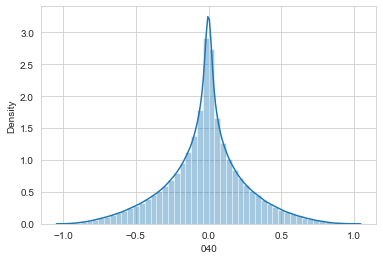

In [217]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

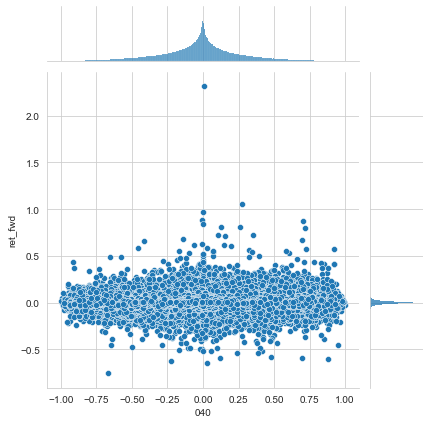

In [218]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [219]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0036899540476769133

In [220]:
# Alpha 041 = power(high * low, 0.5) - vwap
def alpha041(h, l, vwap):
    """power(high * low, 0.5 - vwap"""
    return (power(h.mul(l), 0.5).sub(vwap).stack('ticker').swaplevel())

In [221]:
%%time
alpha = 41
alphas[f'{alpha:03}'] = alpha041(h, l, vwap)

CPU times: total: 2.56 s
Wall time: 2.55 s


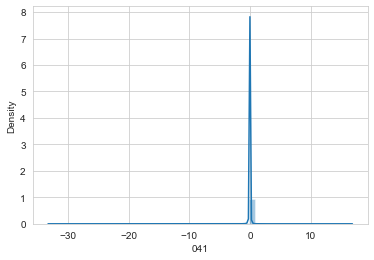

In [222]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

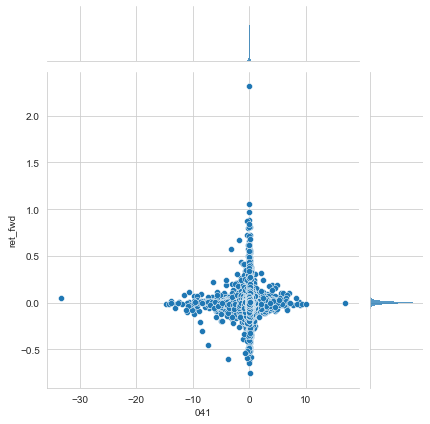

In [223]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [224]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.004641108133457195

In [225]:
# Alpha 042 = rank(vwap - close) / rank(vwap + close)
def alpha042(c, vwap):
    """ rank(vwap - close) / rank(vwap + close) """
    return (rank(vwap.sub(c)).div(rank(vwap.add(c))).stack('ticker').swaplevel())

In [226]:
%%time
alpha = 42
alphas[f'{alpha:03}'] = alpha042(c, vwap)

CPU times: total: 1.98 s
Wall time: 2 s


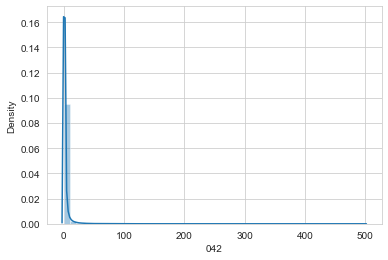

In [227]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

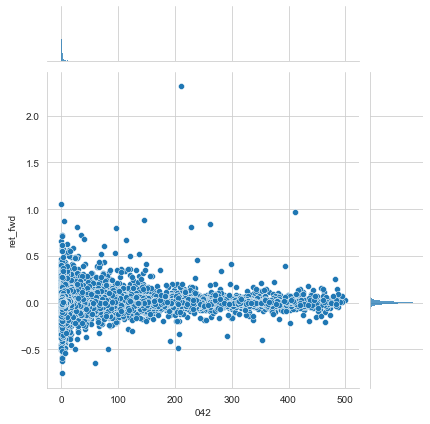

In [228]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [229]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.005585326677598701

In [230]:
# Alpha 043 = ((ts_sum(high, 20) / 20) < high) ? (-1 * ts_delta(high, 2)) : 0
def alpha043(c, adv20):
    """ (ts_rank((volume / adv20), 20) * ts_rank((-1 * ts_delta(close, 7)), 8)) """
    return (ts_rank(v.div(adv20), 20).mul(ts_rank(ts_delta(c, 7).mul(-1), 8)).stack('ticker').swaplevel())

In [231]:
%%time
alpha = 43
alphas[f'{alpha:03}'] = alpha043(c, adv20)

CPU times: total: 7min 27s
Wall time: 7min 29s


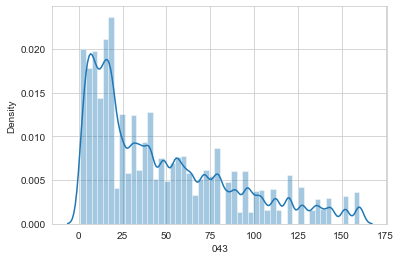

In [232]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

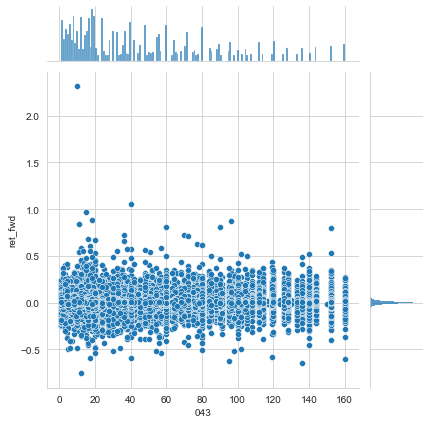

In [233]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [234]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [235]:
# Alpha 044 = -ts_corr(high, rank(volume), 5)
def alpha044(h, v):
    """ -ts_corr(high, rank(volume), 5) """
    return (ts_corr(h, rank(v), 5).replace([-np.inf, np.inf], np.nan).mul(-1).stack('ticker').swaplevel())

In [236]:
%%time
alpha = 44
alphas[f'{alpha:03}'] = alpha044(h, v)

CPU times: total: 3.56 s
Wall time: 3.53 s


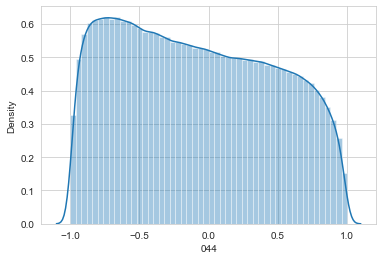

In [237]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

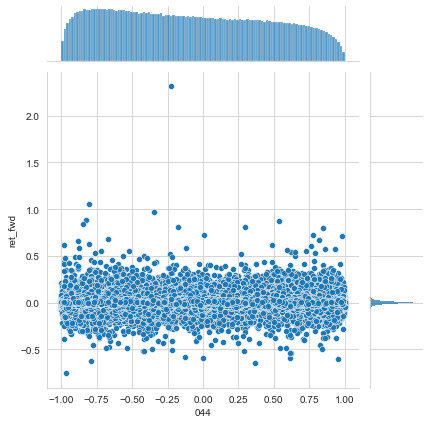

In [238]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [239]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.003521938253365775

In [240]:
# Alpha 045 = -(rank((ts_mean(ts_lag(close, 5), 20)) * ts_corr(close, volume, 2)) * rank(ts_corr(ts_sum(close, 5), ts_sum(close, 20), 2)))
def alpha045(c, v):
    """ -(rank((ts_mean(ts_lag(close, 5), 20)) * ts_corr(close, volume, 2)) *
        rank(ts_corr(ts_sum(close, 5), ts_sum(close, 20), 2))) """
    return (rank(ts_mean(ts_lag(c, 5), 20)).mul(ts_corr(c, v, 2).replace([-np.inf, np.inf], np.nan))
            .mul(rank(ts_corr(ts_sum(c, 5), ts_sum(c, 20), 2))).mul(-1).stack('ticker').swaplevel())

In [241]:
%%time
alpha = 45
alphas[f'{alpha:03}'] = alpha045(c, v)

CPU times: total: 6.02 s
Wall time: 5.93 s


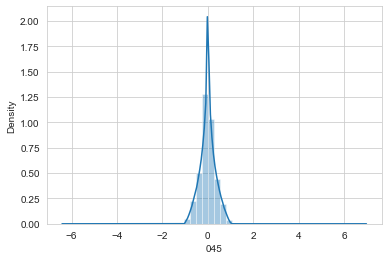

In [242]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

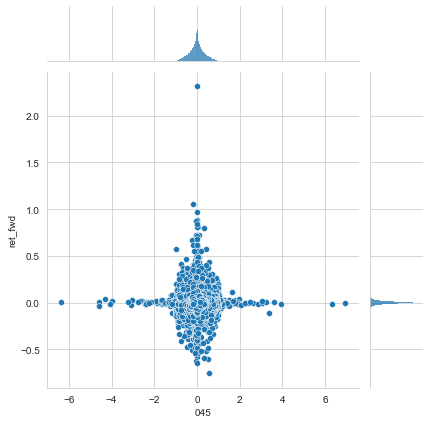

In [243]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [244]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0014893827953681438

In [245]:
# Alpha 046 = 0.25 < ts_lag(ts_delta(close, 10), 10) / 10 - ts_delta(close, 10) / 10 ? -1 : ((ts_lag(ts_delta(close, 10), 10) / 10 - ts_delta(close, 10) / 10 < 0) ? 1 : -ts_delta(close, 1))
def alpha046(c):
    """0.25 < ts_lag(ts_delta(close, 10), 10) / 10 - ts_delta(close, 10) / 10 ? -1
            : ((ts_lag(ts_delta(close, 10), 10) / 10 - ts_delta(close, 10) / 10 < 0) ? 1 : -ts_delta(close, 1))
    """
    cond = ts_lag(ts_delta(c, 10), 10).div(10).sub(ts_delta(c, 10).div(10))
    alpha = pd.DataFrame(-np.ones_like(cond), index=c.index, columns=c.columns)
    alpha[cond.isnull()] = np.nan
    return (cond.where(cond > 0.25, -alpha.where(cond < 0, -ts_delta(c, 1))).stack('ticker').swaplevel())

In [246]:
%%time
alpha = 46
alphas[f'{alpha:03}'] = alpha046(c)

CPU times: total: 2.12 s
Wall time: 2 s


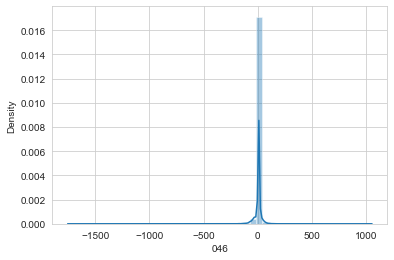

In [247]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

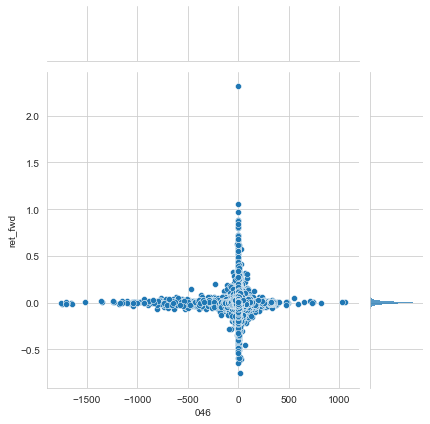

In [248]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [249]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.007942976069462038

In [250]:
# Alpha 047 = rank(ts_corr(ts_lag(open - close, 1), close, 200)) + rank(open - close)
def alpha047(h, c, v, vwap, adv20):
    """ ((((rank((1 / close)) * volume) / adv20) * ((high * rank((high - close))) /
        (ts_sum(high, 5) /5))) - rank((vwap - ts_lag(vwap, 5)))) """
    return (rank(c.pow(-1)).mul(v).div(adv20).mul(h.mul(rank(h.sub(c)).div(ts_mean(h, 5)))
                 .sub(rank(ts_delta(vwap, 5)))).stack('ticker').swaplevel())

In [251]:
%%time
alpha = 47
alphas[f'{alpha:03}'] = alpha047(h, c, v, vwap, adv20)

CPU times: total: 2.33 s
Wall time: 2.23 s


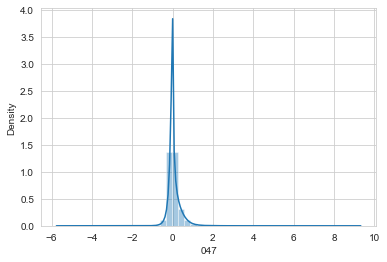

In [252]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

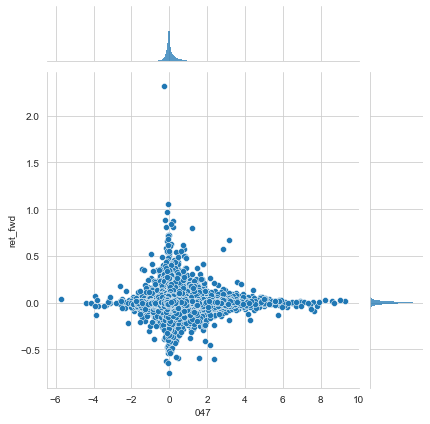

In [253]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [254]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0017355766266824446

In [255]:
# Alpha 048 = (indneutralize(((ts_corr(ts_delta(close, 1), ts_delta(ts_lag(close, 1), 1), 250) *ts_delta(close, 1)) / close), IndClass.subindustry) / ts_sum(((ts_delta(close, 1) / ts_lag(close, 1))^2), 250))
def alpha48(c, industry):
    """(indneutralize(((ts_corr(ts_delta(close, 1), ts_delta(ts_lag(close, 1), 1), 250) *
        ts_delta(close, 1)) / close), IndClass.subindustry) /
        ts_sum(((ts_delta(close, 1) / ts_lag(close, 1))^2), 250))"""
    pass

alpha = 48
# %%time
# alphas[f'{alpha:03}'] = alpha48(o, c)
# alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
# sns.distplot(alphas[f'{alpha:03}']);
# g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);
#
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

In [256]:
# Alpha 049 = ts_delta(ts_lag(close, 10), 10).div(10).sub(ts_delta(close, 10).div(10)) < -0.1 * c ? 1 : -ts_delta(close, 1)
def alpha049(c):
    """ts_delta(ts_lag(close, 10), 10).div(10).sub(ts_delta(close, 10).div(10)) < -0.1 * c ? 1
        : -ts_delta(close, 1)"""
    cond = (ts_delta(ts_lag(c, 10), 10).div(10).sub(ts_delta(c, 10).div(10)) >= -0.1 * c)
    return (-ts_delta(c, 1).where(cond, 1).stack('ticker').swaplevel())

In [257]:
%%time
alpha = 49
alphas[f'{alpha:03}'] = alpha049(c)

CPU times: total: 5.08 s
Wall time: 5.18 s


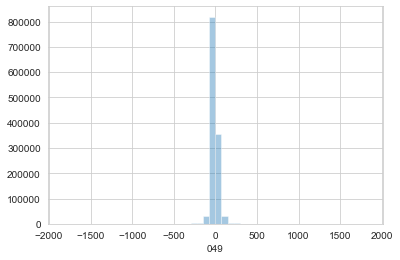

In [258]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}'], kde=False);

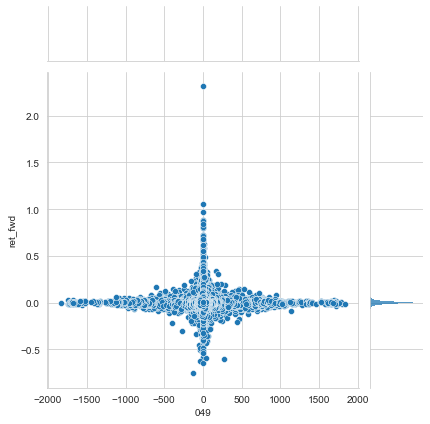

In [259]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [260]:
# Alpha 050 = -ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
def alpha050(v, vwap):
    """-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)"""
    return (ts_max(rank(ts_corr(rank(v), rank(vwap), 5)), 5).mul(-1).stack('ticker').swaplevel())

In [261]:
%%time
alpha = 50
alphas[f'{alpha:03}'] = alpha050(v, vwap)

CPU times: total: 3.78 s
Wall time: 3.79 s


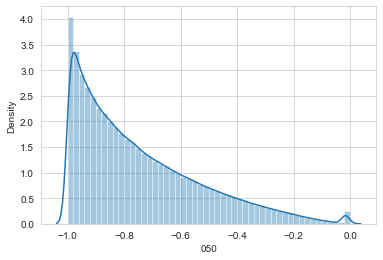

In [262]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

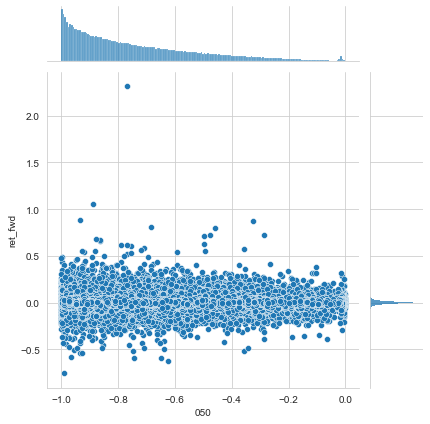

In [263]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [264]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [265]:
# Alpha 051 = ts_delta(ts_lag(close, 10), 10).div(10).sub(ts_delta(close, 10).div(10)) < -0.05 * c ? 1 : -ts_delta(close, 1)
def alpha051(c):
    """ ts_delta(ts_lag(close, 10), 10).div(10).sub(ts_delta(close, 10).div(10)) < -0.05 * c ? 1
        : -ts_delta(close, 1) """
    cond = (ts_delta(ts_lag(c, 10), 10).div(10).sub(ts_delta(c, 10).div(10)) >= -0.05 * c)
    return (-ts_delta(c, 1).where(cond, 1).stack('ticker').swaplevel())

In [266]:
%%time
alpha = 51
alphas[f'{alpha:03}'] = alpha051(c)

CPU times: total: 1.91 s
Wall time: 1.9 s


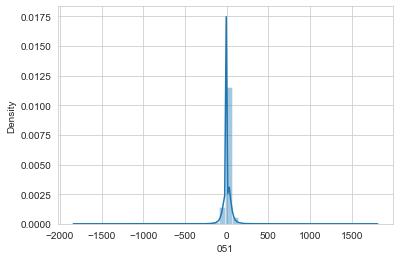

In [267]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

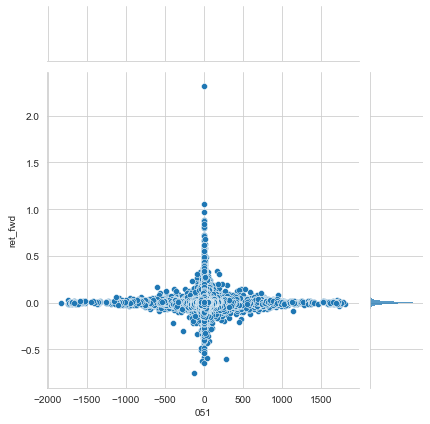

In [268]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [269]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.010719549875629397

In [270]:
# Alpha 052 = (ts_lag(ts_min(low, 5), 5) - ts_min(low, 5)) * rank((ts_sum(returns, 240) - ts_sum(returns, 20)) / 220) *  ts_rank(volume, 5)
def alpha052(l, v, r):
    """ (ts_lag(ts_min(low, 5), 5) - ts_min(low, 5)) *
        rank((ts_sum(returns, 240) - ts_sum(returns, 20)) / 220) * ts_rank(volume, 5) """
    return (ts_delta(ts_min(l, 5), 5).mul(rank(ts_sum(r, 240).sub(ts_sum(r, 20)).div(220))).mul(ts_rank(v, 5))
            .stack('ticker').swaplevel())

In [271]:
%%time
alpha = 52
alphas[f'{alpha:03}'] = alpha052(l, v, r)

CPU times: total: 3min 52s
Wall time: 3min 53s


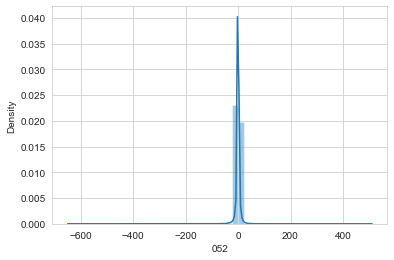

In [272]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

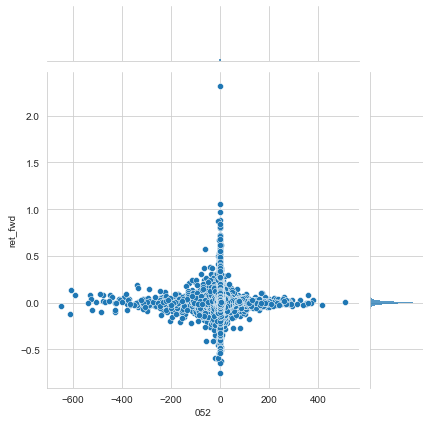

In [273]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [274]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.007738686014217677

In [275]:
# Alpha 053 = ((ts_sum(high, 20) / 20) < high) ? (-1 * ts_delta(high, 2)) : 0
def alpha053(h, l, c):
    """ -1 * ts_delta(1 - (high - close) / (close - low), 9) """
    inner = (c.sub(l)).add(1e-6)
    return (ts_delta(h.sub(c).mul(-1).add(1).div(c.sub(l).add(1e-6)), 9).mul(-1).stack('ticker').swaplevel())

In [276]:
%%time
alpha = 53
alphas[f'{alpha:03}'] = alpha053(h, l, c)

CPU times: total: 11.9 s
Wall time: 12 s


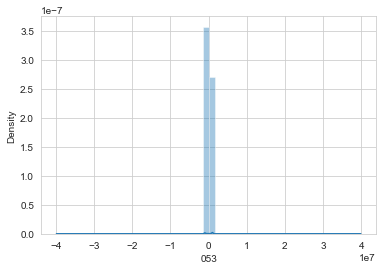

In [277]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

MemoryError: Unable to allocate 30.8 GiB for an array with shape (4136081405,) and data type float64

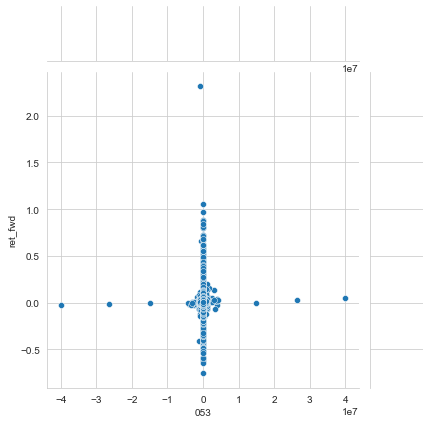

In [278]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

In [279]:
# Alpha 054 = -(low - close) * power(open, 5) / ((low - high) * power(close, 5))
def alpha054(o, h, l, c):
    """ -(low - close) * power(open, 5) / ((low - high) * power(close, 5)) """
    return (l.sub(c).mul(o.pow(5)).mul(-1).div(l.sub(h).replace(0, -0.0001).mul(c ** 5))
            .stack('ticker').swaplevel())

In [280]:
%%time
alpha = 54
alphas[f'{alpha:03}'] = alpha054(o, h, l, c)

CPU times: total: 2.44 s
Wall time: 2.5 s


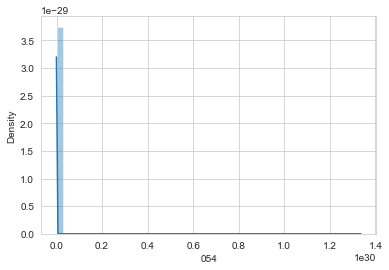

In [281]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

MemoryError: Unable to allocate 326. TiB for an array with shape (44839793172238,) and data type float64

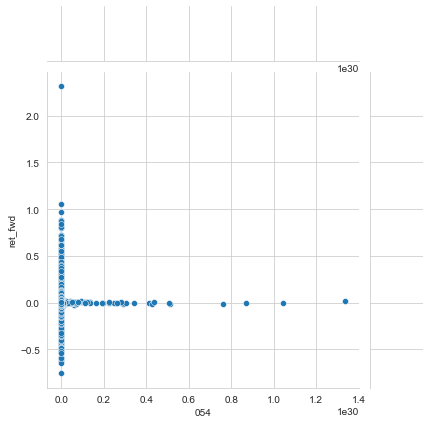

In [282]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [283]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0021733633278055997

In [284]:
pd.Series(mi).tail()

47    0.001736
50    0.000000
51    0.010720
52    0.007739
54    0.002173
dtype: float64

In [285]:
# Alpha 055 = (-1 * ts_corr(rank(((close - ts_min(low, 12)) / (ts_max(high, 12) - ts_min(low,12)))), rank(volume), 6))
def alpha055(h, l, c):
    """ (-1 * ts_corr(rank(((close - ts_min(low, 12)) / (ts_max(high, 12) - ts_min(low,12)))),
                    rank(volume), 6)) """
    return (ts_corr(rank(c.sub(ts_min(l, 12)).div(ts_max(h, 12).sub(ts_min(l, 12))
                              .replace(0, 1e-6))), rank(v), 6).replace([-np.inf, np.inf], np.nan).mul(-1)
            .stack('ticker').swaplevel())

In [286]:
%%time
alpha = 55
alphas[f'{alpha:03}'] = alpha055(h, l, c)

CPU times: total: 4.59 s
Wall time: 4.65 s


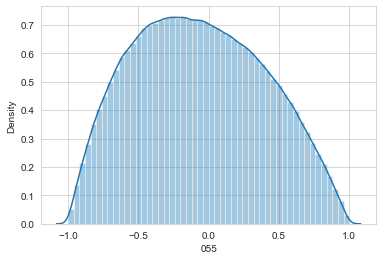

In [287]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

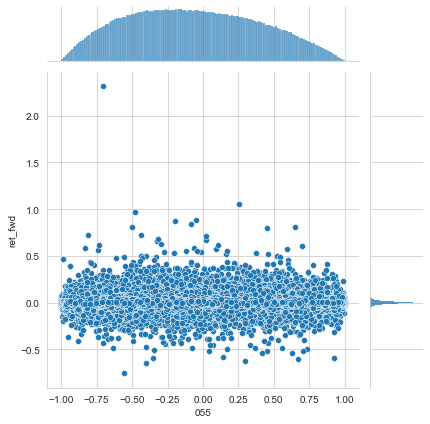

In [288]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [289]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [290]:
# Alpha 056 = -rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * rank((returns * cap))
def alpha056(r, cap):
    """ -rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * rank((returns * cap)) """
    pass

In [291]:
# Alpha 057 = rank(ts_corr(ts_lag(open - close, 1), close, 200)) + rank(open - close)
def alpha057(c, vwap):
    """ -(close - vwap) / ts_weighted_mean(rank(ts_argmax(close, 30)), 2) """
    return (c.sub(vwap.add(1e-5)).div(ts_weighted_mean(rank(ts_argmax(c, 30)))).mul(-1)
            .stack('ticker').swaplevel())

In [292]:
%%time
alpha = 57
alphas[f'{alpha:03}'] = alpha057(c, vwap)

CPU times: total: 2min 36s
Wall time: 2min 41s


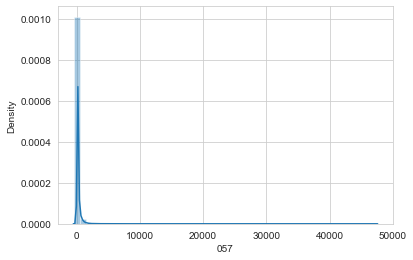

In [293]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

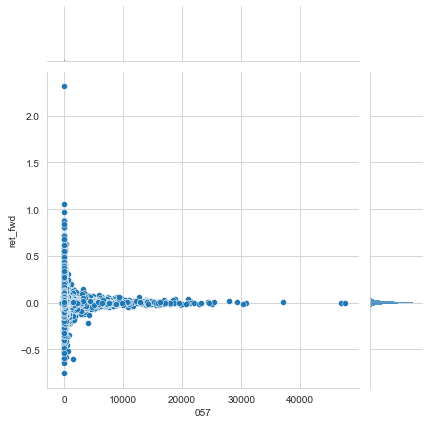

In [294]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [295]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.009588156487899013

In [ ]:
# Alpha 058 = (indneutralize(((ts_corr(ts_delta(close, 1), ts_delta(ts_lag(close, 1), 1), 250) *ts_delta(close, 1)) / close), IndClass.subindustry) / ts_sum(((ts_delta(close, 1) / ts_lag(close, 1))^2), 250))
def alpha58(v, wvap, sector):
    """ (-1 * ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(vwap, IndClass.sector), volume, 3), 7), 5)) """
    pass

In [ ]:
# Alpha 059 = (indneutralize(((ts_corr(ts_delta(close, 1), ts_delta(ts_lag(close, 1), 1), 250) *ts_delta(close, 1)) / close), IndClass.subindustry) / ts_sum(((ts_delta(close, 1) / ts_lag(close, 1))^2), 250))
def alpha59(v, wvap, industry):
    """ -ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(vwap, IndClass.industry), volume, 4), 16), 8) """
    pass

In [296]:
# Alpha 060 = -ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
def alpha060(l, h, c, v):
    """ -((2 * scale(rank(((((close - low) - (high - close)) / (high - low)) * volume)))) -scale(rank(ts_argmax(close, 10)))) """
    return (scale(rank(c.mul(2).sub(l).sub(h).div(h.sub(l).replace(0, 1e-5)).mul(v))).mul(2)
            .sub(scale(rank(ts_argmax(c, 10)))).mul(-1).stack('ticker').swaplevel())

In [297]:
%%time
alpha = 60
alphas[f'{alpha:03}'] = alpha060(l, h, c, v)

CPU times: total: 2min 39s
Wall time: 2min 47s


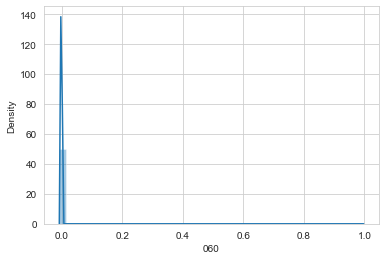

In [298]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

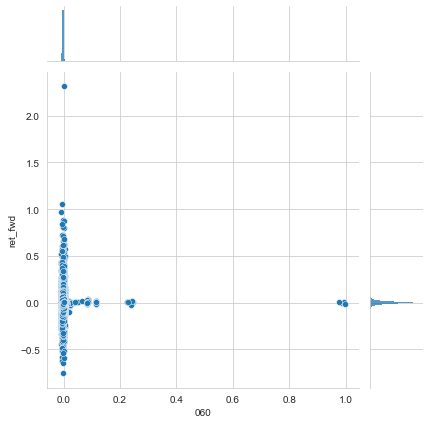

In [299]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [300]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [301]:
# Alpha 061 = (rank((vwap - ts_min(vwap, 16.1219))) < rank(ts_corr(vwap, adv180, 17.9282)))
def alpha061(v, vwap):
    """ rank((vwap - ts_min(vwap, 16))) < rank(ts_corr(vwap, adv180, 17)) """
    return (rank(vwap.sub(ts_min(vwap, 16))).lt(rank(ts_corr(vwap, ts_mean(v, 180), 18))).astype(int)
            .stack('ticker').swaplevel())

In [302]:
%%time
alpha = 61
alphas[f'{alpha:03}'] = alpha061(v, vwap)

CPU times: total: 6.84 s
Wall time: 8.82 s


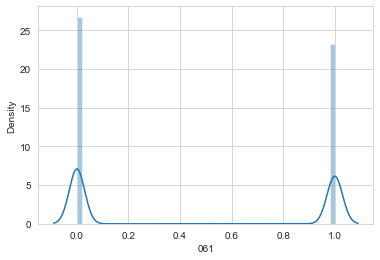

In [303]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

In [304]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
061                                                                         
0    671702.0  0.000458  0.025757 -0.757755 -0.009681  0.000413  0.010529   
1    583391.0  0.000724  0.025759 -0.643066 -0.009615  0.000599  0.010819   

          max  
061            
0    2.317073  
1    0.972222

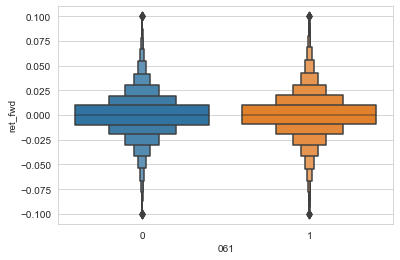

In [305]:
g = sns.boxenplot(x=f'{alpha:03}', y='ret_fwd', data=alphas[alphas.ret_fwd.between(-.1, .1)]);

In [306]:
# Alpha 062 = ((rank(ts_corr(vwap, ts_sum(adv20, 22.4101), 9.91009)) < rank(((rank(open) +rank(open)) < (rank(((high + low) / 2)) + rank(high))))) * -1)
def alpha062(o, h, l, vwap, adv20):
    """ ((rank(ts_corr(vwap, ts_sum(adv20, 22.4101), 9.91009)) <
    rank(((rank(open) + rank(open)) < (rank(((high + low) / 2)) + rank(high))))) * -1) """
    return (rank(ts_corr(vwap, ts_sum(adv20, 22), 9)).lt(rank(rank(o).mul(2)).lt(rank(h.add(l).div(2))
                    .add(rank(h)))).mul(-1).stack('ticker').swaplevel())

In [307]:
%%time
alpha = 62
alphas[f'{alpha:03}'] = alpha062(o, h, l, vwap, adv20)

CPU times: total: 4.67 s
Wall time: 4.86 s


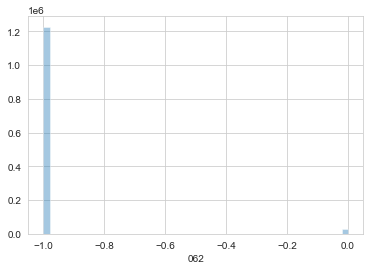

In [308]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}'], kde=False);

In [309]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
062                                                                          
-1   1227397.0  0.000582  0.025877 -0.757755 -0.009697  0.000496  0.010711   
 0     27696.0  0.000545  0.019795 -0.441048 -0.007788  0.000648  0.008919   

          max  
062            
-1   2.317073  
 0   0.436170

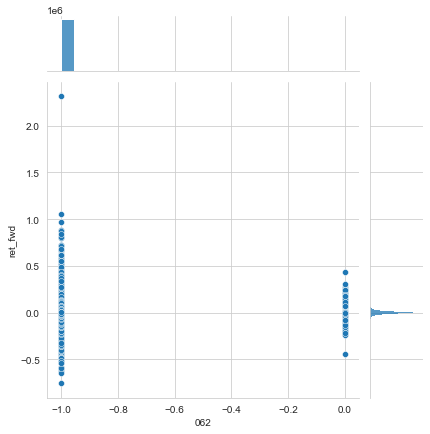

In [310]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [311]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0003293670528405901

In [ ]:
# Alpha 063 = ((rank(ts_weighted_mean(ts_delta(IndNeutralize(close, IndClass.industry), 2.25164), 8.22237))- rank(ts_weighted_mean(ts_corr(((vwap * 0.318108) + (open * (1 - 0.318108))), ts_sum(adv180,37.2467), 13.557), 12.2883))) * -1)
def alpha63(v, wvap, industry):
    """ ((rank(ts_weighted_mean(ts_delta(IndNeutralize(close, IndClass.industry), 2), 8)) -
        rank(ts_weighted_mean(ts_corr(((vwap * 0.318108) + (open * (1 - 0.318108))),
                                        ts_sum(adv180, 37), 13), 12))) * -1) """
    pass

alpha = 63
# %%time
# alphas[f'{alpha:03}'] = alpha48(o, c)
# alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
# sns.distplot(alphas[f'{alpha:03}']);
# g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);
#
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

In [312]:
# Alpha 064 = -ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
def alpha064(o, h, l, v, vwap):
    """ ((rank(ts_corr(ts_sum(((open * 0.178404) + (low * (1 - 0.178404))), 12.7054)
     ,ts_sum(adv120, 12.7054), 16.6208)) <
        rank(ts_delta(((((high + low) / 2) * 0.178404) + (vwap * (1 -0.178404))), 3.69741))) * -1) """
    w = 0.178404
    return (rank(ts_corr(ts_sum(o.mul(w).add(l.mul(1 - w)), 12), ts_sum(ts_mean(v, 120), 12), 16))
            .lt(rank(ts_delta(h.add(l).div(2).mul(w).add(vwap.mul(1 - w)), 3))).mul(-1)
            .stack('ticker').swaplevel())

In [313]:
%%time
alpha = 64
alphas[f'{alpha:03}'] = alpha064(o, h, l, v, vwap)

CPU times: total: 4.86 s
Wall time: 4.71 s


In [314]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
064                                                                         
-1   590331.0  0.000463  0.025842 -0.757755 -0.009714  0.000410  0.010584   
 0   664762.0  0.000687  0.025683 -0.619752 -0.009595  0.000576  0.010741   

          max  
064            
-1   2.317073  
 0   0.869835

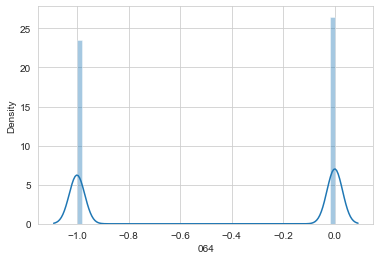

In [315]:
sns.distplot(alphas[f'{alpha:03}']);

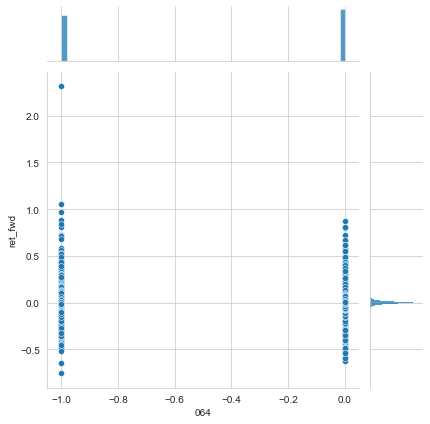

In [316]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [317]:
# Alpha 065 = ((rank(ts_corr(((open * 0.00817205) + (vwap * (1 - 0.00817205))), ts_sum(adv60,8.6911), 6.40374)) <  rank((open - ts_min(open, 13.635)))) * -1)
def alpha065(o, v, vwap):
    """ ((rank(ts_corr(((open * 0.00817205) + (vwap * (1 - 0.00817205))), ts_sum(adv60,8.6911), 6.40374)) <
        rank((open - ts_min(open, 13.635)))) * -1) """
    w = 0.00817205
    return (rank(ts_corr(o.mul(w).add(vwap.mul(1 - w)), ts_mean(ts_mean(v, 60), 9), 6))
            .lt(rank(o.sub(ts_min(o, 13)))).mul(-1).stack('ticker').swaplevel())

In [318]:
%%time
alpha = 65
alphas[f'{alpha:03}'] = alpha065(o, v, vwap)

CPU times: total: 4.11 s
Wall time: 4.11 s


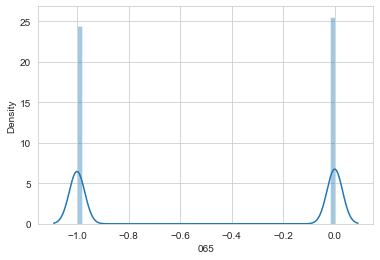

In [319]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

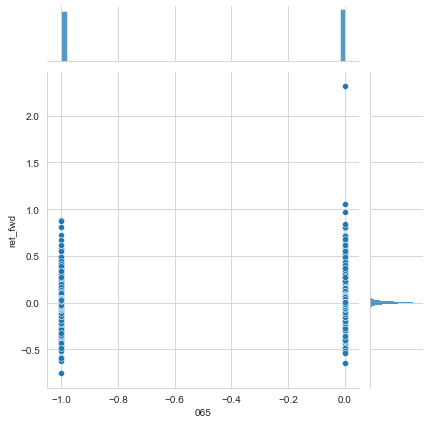

In [320]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [321]:
# Alpha 066 = ((rank(ts_weighted_mean(ts_delta(vwap, 3.51013), 7.23052)) + ts_rank(ts_weighted_mean(((((low* 0.96633) + (low * (1 - 0.96633))) - vwap) / (open - ((high + low) / 2))), 11.4157), 6.72611)) * -1)
def alpha066(l, h, vwap):
    """ ((rank(ts_weighted_mean(ts_delta(vwap, 3.51013), 7.23052)) +
        ts_rank(ts_weighted_mean(((((low* 0.96633) + (low * (1 - 0.96633))) - vwap) /
                                    (open - ((high + low) / 2))), 11.4157), 6.72611)) * -1) """
    w = 0.96633
    return (rank(ts_weighted_mean(ts_delta(vwap, 4), 7))
            .add(ts_rank(ts_weighted_mean(l.mul(w).add(l.mul(1 - w)).sub(vwap)
                                          .div(o.sub(h.add(l).div(2)).add(1e-3)), 11), 7)).mul(-1)
            .stack('ticker').swaplevel())

In [322]:
%%time
alpha = 66
alphas[f'{alpha:03}'] = alpha066(l, h, vwap)

CPU times: total: 4min 11s
Wall time: 4min 20s


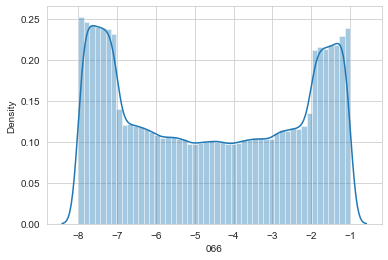

In [323]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

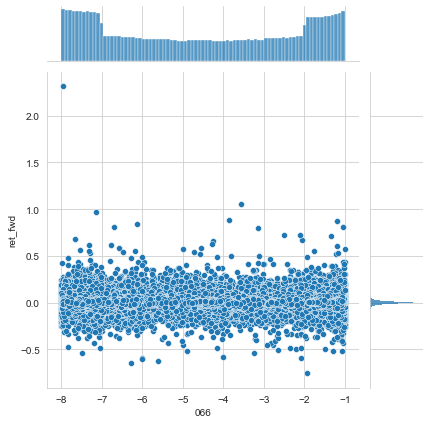

In [324]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [325]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0026495938018937792

In [ ]:
# Alpha 067 = (rank(ts_delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < rank(ts_corr(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
def alpha067(h, v, sector, subindustry):
    """(power(rank((high - ts_min(high, 2.14593))), rank(ts_corr(IndNeutralize(vwap,IndClass.sector),
                IndNeutralize(adv20, IndClass.subindustry), 6.02936))) * -1)
    """
    pass

alpha = 67
# %%time
# alphas[f'{alpha:03}'] = alpha056(r, cap)
# alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
# sns.distplot(alphas[f'{alpha:03}']);
# g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);
#
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

In [326]:
# Alpha 068 = ((ts_rank(ts_corr(rank(high), rank(adv15), 8.91644), 13.9333) < rank(ts_delta(((close * 0.518371) + (low * (1 - 0.518371))), 1.06157))) * -1)
def alpha068(h, c, v):
    """ ((ts_rank(ts_corr(rank(high), rank(adv15), 8.91644), 13.9333) <
        rank(ts_delta(((close * 0.518371) + (low * (1 - 0.518371))), 1.06157))) * -1) """
    w = 0.518371
    return (ts_rank(ts_corr(rank(h), rank(ts_mean(v, 15)), 9), 14)
            .lt(rank(ts_delta(c.mul(w).add(l.mul(1 - w)), 1))).mul(-1)
            .stack('ticker').swaplevel())

In [327]:
%%time
alpha = 68
alphas[f'{alpha:03}'] = alpha068(h, c, v)

CPU times: total: 4min 2s
Wall time: 4min 25s


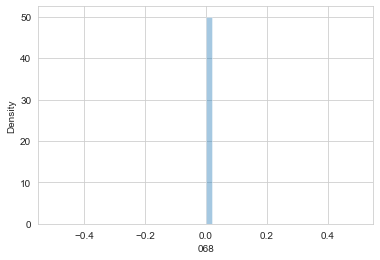

In [328]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

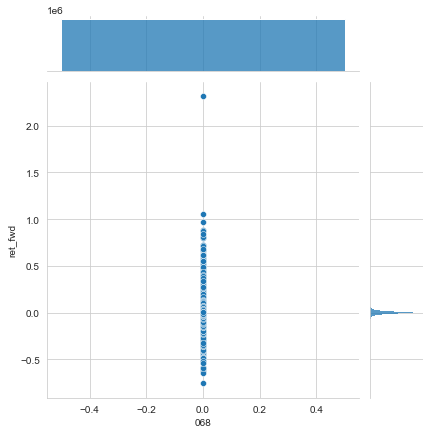

In [329]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [330]:
# Alpha 069 = ((power(rank(ts_max(ts_delta(IndNeutralize(vwap, IndClass.industry), 2.72412),4.79344)), Ts_Rank(ts_corr(((close * 0.490655) + (vwap * (1 - 0.490655))), adv20, 4.92416),9.0615))) * -1)
def alpha069(c, vwap, industry):
    """ ((power(rank(ts_max(ts_delta(IndNeutralize(vwap, IndClass.industry), 2.72412),4.79344)),
    Ts_Rank(ts_corr(((close * 0.490655) + (vwap * (1 - 0.490655))), adv20, 4.92416),9.0615))) * -1) """
    pass

In [331]:
# Alpha 070 = ((power(rank(ts_delta(vwap, 1.29456)), ts_rank(ts_corr(IndNeutralize(close,IndClass.industry), adv50, 17.8256), 17.9171))) * -1)
def alpha076(c, v, vwap, industry):
    """ ((power(rank(ts_delta(vwap, 1.29456)),
        ts_rank(ts_corr(IndNeutralize(close, IndClass.industry), adv50, 17.8256), 17.9171))) * -1) """
    pass


alpha = 70

In [332]:
# Alpha 071 = -ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
def alpha071(o, c, v, vwap):
    """ max(ts_rank(ts_weighted_mean(ts_corr(ts_rank(close, 3.43976), ts_rank(adv180,12.0647), 18.0175), 4.20501), 15.6948),
            ts_rank(ts_weighted_mean((rank(((low + open) - (vwap +vwap)))^2), 16.4662), 4.4388)) """

    s1 = (ts_rank(ts_weighted_mean(ts_corr(ts_rank(c, 3), ts_rank(ts_mean(v, 180), 12), 18), 4), 16))
    s2 = (ts_rank(ts_weighted_mean(rank(l.add(o).sub(vwap.mul(2))).pow(2), 16), 4))
    return (s1.where(s1 > s2, s2).stack('ticker').swaplevel())

In [333]:
%%time
alpha = 71
alphas[f'{alpha:03}'] = alpha071(o, c, v, vwap)

CPU times: total: 11min 56s
Wall time: 11min 59s


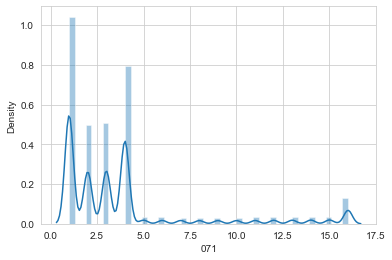

In [334]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

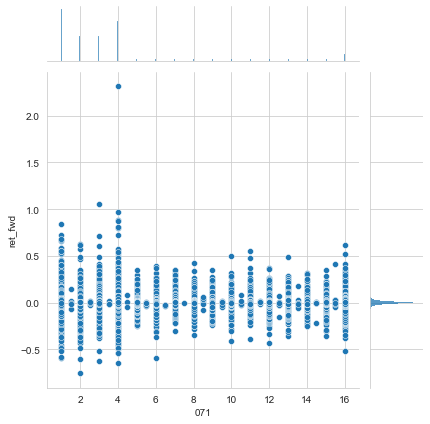

In [335]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [336]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.005510631672746236

In [337]:
# Alpha 072 = (rank(ts_weighted_mean(ts_corr(((high + low) / 2), adv40, 8.93345), 10.1519)) / rank(ts_weighted_mean(ts_corr(ts_rank(vwap, 3.72469), ts_rank(volume, 18.5188), 6.86671), 2.95011)))
def alpha072(h, l, v, vwap):
    """ (rank(ts_weighted_mean(ts_corr(((high + low) / 2), adv40, 8.93345), 10.1519)) /
        rank(ts_weighted_mean(ts_corr(ts_rank(vwap, 3.72469), ts_rank(volume, 18.5188), 6.86671), 2.95011)))
    """
    return (rank(ts_weighted_mean(ts_corr(h.add(l).div(2), ts_mean(v, 40), 9), 10))
            .div(rank(ts_weighted_mean(ts_corr(ts_rank(vwap, 3), ts_rank(v, 18), 6), 2)))
            .stack('ticker').swaplevel())

In [338]:
%%time
alpha = 72
alphas[f'{alpha:03}'] = alpha072(h, l, v, vwap)

CPU times: total: 7min 41s
Wall time: 7min 43s


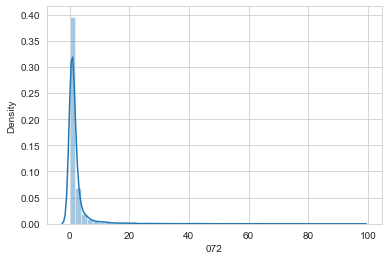

In [339]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

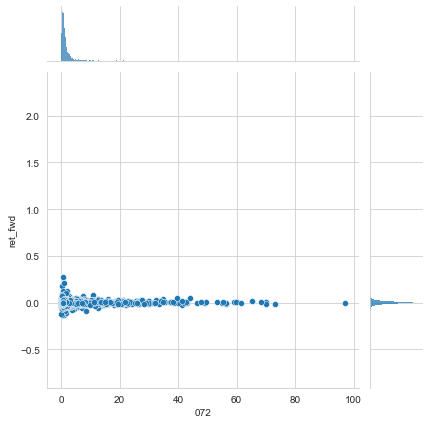

In [340]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [341]:
# Alpha 073 = (max(rank(ts_weighted_mean(ts_delta(vwap, 4.72775), 2.91864)), ts_rank(ts_weighted_mean(((ts_delta(((open * 0.147155) +  (low * (1 - 0.147155))), 2.03608) / ((open *0.147155) + (low * (1 - 0.147155)))) * -1), 3.33829), 16.7411)) * -1)
def alpha073(l, vwap):
    """ (max(rank(ts_weighted_mean(ts_delta(vwap, 4.72775), 2.91864)),
        ts_rank(ts_weighted_mean(((ts_delta(((open * 0.147155) + (low * (1 - 0.147155))), 2.03608) /
            ((open *0.147155) + (low * (1 - 0.147155)))) * -1), 3.33829), 16.7411)) * -1) """
    w = 0.147155
    s1 = rank(ts_weighted_mean(ts_delta(vwap, 5), 3))
    s2 = (ts_rank(ts_weighted_mean(ts_delta(o.mul(w).add(l.mul(1 - w)), 2)
                                   .div(o.mul(w).add(l.mul(1 - w)).mul(-1)), 3), 16))
    print(s2)
    return (s1.where(s1 > s2, s2).mul(-1).stack('ticker').swaplevel())

In [342]:
%%time
alpha = 73
alphas[f'{alpha:03}'] = alpha073(l, vwap)

ticker         A   AAL   AAP  AAPL   ABC  ABT   ACN  ADBE   ADI   ADM  ...  \
date                                                                   ...   
2007-01-04   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   NaN  ...   
2007-01-05   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   NaN  ...   
2007-01-08   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   NaN  ...   
2007-01-09   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   NaN  ...   
2007-01-10   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   NaN  ...   
...          ...   ...   ...   ...   ...  ...   ...   ...   ...   ...  ...   
2016-12-22   8.0   5.0  11.0  12.0   9.0  7.0  16.0  10.0   6.0  14.0  ...   
2016-12-23  10.0  14.0  15.0  14.0  12.0  6.0  15.0  12.0   8.0  15.0  ...   
2016-12-27   7.0  16.0  13.0  13.0  10.0  5.0  12.0  11.0   7.0  13.0  ...   
2016-12-28  11.0  16.0  10.0  11.0   7.0  6.0  12.0  14.0   7.0  11.0  ...   
2016-12-29  14.0  16.0  10.0  12.0   6.0  9.0  12.0  14.0  13.0 

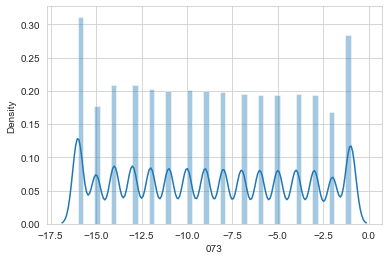

In [343]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

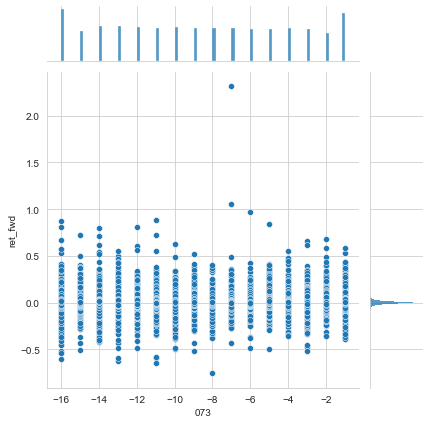

In [344]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [345]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [346]:
# Alpha 074 = ((rank(ts_corr(close, ts_sum(adv30, 37.4843), 15.1365)) < rank(ts_corr(rank(((high * 0.0261661) + (vwap * (1 - 0.0261661)))), rank(volume), 11.4791)))* -1)
def alpha074(v, vwap):
    """ ((rank(ts_corr(close, ts_sum(adv30, 37.4843), 15.1365)) <
        rank(ts_corr(rank(((high * 0.0261661) + (vwap * (1 - 0.0261661)))), rank(volume), 11.4791)))* -1) """
    w = 0.0261661
    return (rank(ts_corr(c, ts_mean(ts_mean(v, 30), 37), 15))
            .lt(rank(ts_corr(rank(h.mul(w).add(vwap.mul(1 - w))), rank(v), 11))).mul(-1)
            .stack('ticker').swaplevel())

In [347]:
%%time
alpha = 74
alphas[f'{alpha:03}'] = alpha074(v, vwap)

CPU times: total: 6.25 s
Wall time: 6.38 s


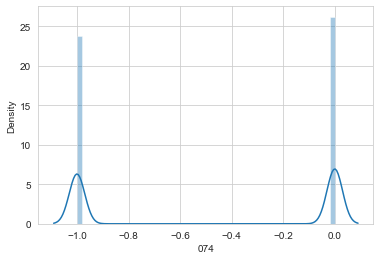

In [348]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

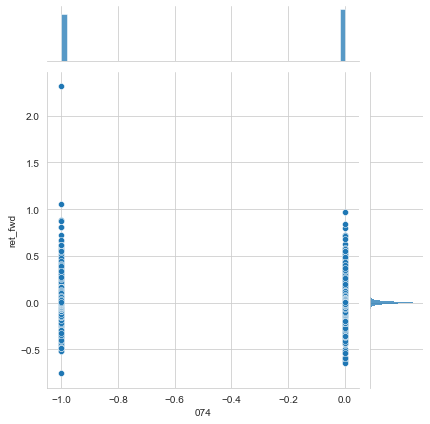

In [349]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [350]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
074                                                                         
-1   597450.0  0.000514  0.025855 -0.757755 -0.009724  0.000471  0.010704   
 0   657643.0  0.000642  0.025670 -0.643066 -0.009582  0.000525  0.010632   

          max  
074            
-1   2.317073  
 0   0.972222

In [351]:
# Alpha 075 = (rank(ts_corr(vwap, volume, 4.24304)) < rank(ts_corr(rank(low), rank(adv50),12.4413)))
def alpha075(l, v, vwap):
    """ (rank(ts_corr(vwap, volume, 4.24304)) < rank(ts_corr(rank(low), rank(adv50),12.4413))) """
    return (rank(ts_corr(vwap, v, 4)).lt(rank(ts_corr(rank(l), rank(ts_mean(v, 50)), 12))).astype(int)
            .stack('ticker').swaplevel())

In [352]:
%%time
alpha = 75
alphas[f'{alpha:03}'] = alpha075(l, v, vwap)

CPU times: total: 5.53 s
Wall time: 5.47 s


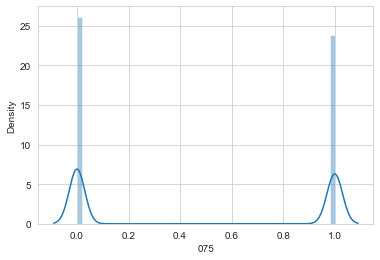

In [353]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

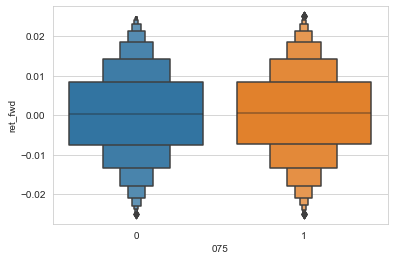

In [354]:
g = sns.boxenplot(x=f'{alpha:03}', y='ret_fwd', data=alphas[alphas.ret_fwd.between(-.025, .025)]);

In [355]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
075                                                                         
0    656509.0  0.000545  0.026144 -0.757755 -0.009674  0.000472  0.010631   
1    598584.0  0.000621  0.025328 -0.607908 -0.009625  0.000529  0.010706   

          max  
075            
0    2.317073  
1    0.814423

In [356]:
# Alpha 076 = (rank(ts_delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < rank(ts_corr(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
def alpha076(l, vwap, sector):
    """ (max(rank(ts_weighted_mean(ts_delta(vwap, 1.24383), 11.8259)),
            ts_rank(ts_weighted_mean(ts_rank(ts_corr(IndNeutralize(low, IndClass.sector), adv81,8.14941), 19.569), 17.1543), 19.383)) * -1) """
    pass


alpha = 76

In [357]:
# Alpha 077 = min(rank(ts_weighted_mean(((((high + low) / 2) + high) - (vwap + high)), 20.0451)), rank(ts_weighted_mean(ts_corr(((high + low) / 2), adv40, 3.1614), 5.64125)))
def alpha077(l, h, vwap):
    """ min(rank(ts_weighted_mean(((((high + low) / 2) + high) - (vwap + high)), 20.0451)),
            rank(ts_weighted_mean(ts_corr(((high + low) / 2), adv40, 3.1614), 5.64125))) """
    s1 = rank(ts_weighted_mean(h.add(l).div(2).sub(vwap), 20))
    s2 = rank(ts_weighted_mean(ts_corr(h.add(l).div(2), ts_mean(v, 40), 3), 5))
    return (s1.where(s1 < s2, s2).stack('ticker').swaplevel())

In [358]:
%%time
alpha = 77
alphas[f'{alpha:03}'] = alpha077(l, h, vwap)

CPU times: total: 4.81 s
Wall time: 4.6 s


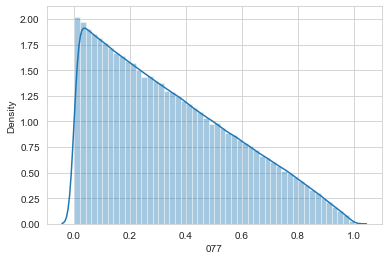

In [359]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

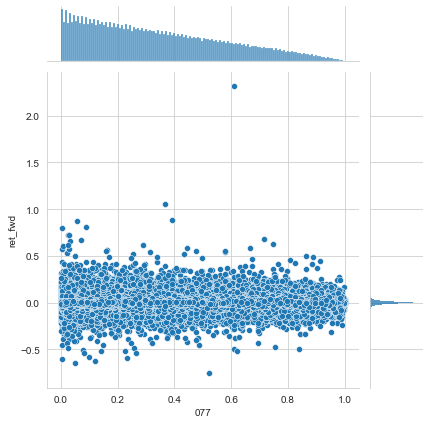

In [360]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [361]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0015127132539287658

In [362]:
# Alpha 078 = (rank(ts_corr(ts_sum(((low * 0.352233) + (vwap * (1 - 0.352233))), 19.7428), ts_sum(adv40, 19.7428), 6.83313))^rank(ts_corr(rank(vwap), rank(volume), 5.77492)))
def alpha078(l, v, vwap):
    """ (rank(ts_corr(ts_sum(((low * 0.352233) + (vwap * (1 - 0.352233))), 19.7428),
        ts_sum(adv40, 19.7428), 6.83313))^rank(ts_corr(rank(vwap), rank(volume), 5.77492))) """
    w = 0.352233
    return (rank(ts_corr(ts_sum((l.mul(w).add(vwap.mul(1 - w))), 19), ts_sum(ts_mean(v, 40), 19), 6))
            .pow(rank(ts_corr(rank(vwap), rank(v), 5))).stack('ticker').swaplevel())

In [363]:
%%time
alpha = 78
alphas[f'{alpha:03}'] = alpha078(l, v, vwap)

CPU times: total: 6.38 s
Wall time: 6.33 s


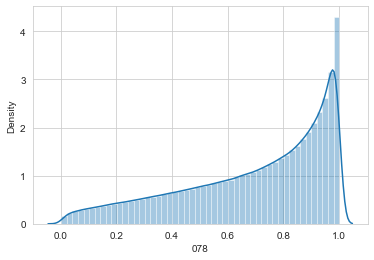

In [364]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

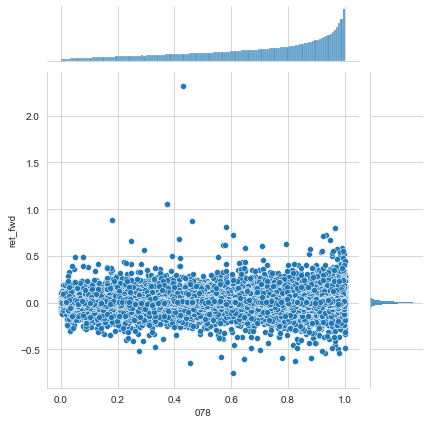

In [365]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [366]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [ ]:
# Alpha 079 = (rank(ts_delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < rank(ts_corr(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
def alpha079(o, v, sector):
    """ (rank(ts_delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) <
        rank(ts_corr(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644))) """
    pass

In [ ]:
# Alpha 080 = ((power(rank(sign(ts_delta(IndNeutralize(((open * 0.868128) + (high * (1 - 0.868128))),IndClass.industry), 4.04545))), ts_rank(ts_corr(high, adv10, 5.11456), 5.53756)) * -1)
def alpha080(h, industry):
    """ ((power(rank(sign(ts_delta(IndNeutralize(((open * 0.868128) + (high * (1 - 0.868128))),IndClass.industry), 4.04545))), ts_rank(ts_corr(high, adv10, 5.11456), 5.53756)) * -1) """
    pass

In [367]:
# Alpha 081 = -(rank(log(ts_product(rank((rank(ts_corr(vwap, ts_sum(adv10, 49.6054),8.47743))^4)), 14.9655))) < rank(ts_corr(rank(vwap), rank(volume), 5.07914)))
def alpha081(v, vwap):
    """ -(rank(log(ts_product(rank((rank(ts_corr(vwap, ts_sum(adv10, 49.6054),8.47743))^4)), 14.9655))) <
        rank(ts_corr(rank(vwap), rank(volume), 5.07914))) """
    return (rank(log(ts_product(rank(rank(ts_corr(vwap, ts_sum(ts_mean(v, 10), 50), 8)).pow(4)), 15)))
            .lt(rank(ts_corr(rank(vwap), rank(v), 5))).mul(-1).stack('ticker').swaplevel())

In [368]:
%%time
alpha = 81
alphas[f'{alpha:03}'] = alpha081(v, vwap)

CPU times: total: 2min 25s
Wall time: 2min 26s


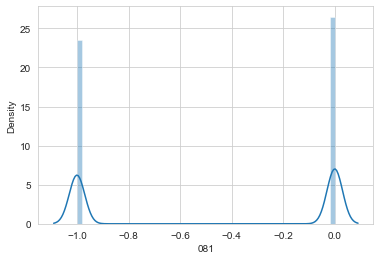

In [369]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

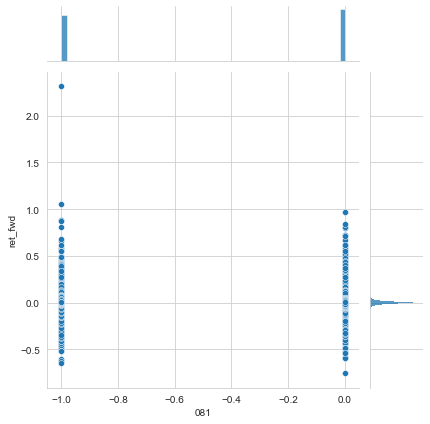

In [370]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [ ]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

In [ ]:
# Alpha 082 = -rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * rank((returns * cap))
def alpha082(o, v, sector):
    """ (min(rank(ts_weighted_mean(ts_delta(open, 1.46063), 14.8717)),
        ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(volume, IndClass.sector),
        ((open * 0.634196) +(open * (1 - 0.634196))), 17.4842), 6.92131), 13.4283)) * -1) """
    pass

In [371]:
# Alpha 083 = (rank(ts_lag((high - low) / ts_mean(close, 5), 2)) * rank(rank(volume)) / (((high - low) / ts_mean(close, 5) / (vwap - close)))
def alpha083(h, l, c):
    """ (rank(ts_lag((high - low) / ts_mean(close, 5), 2)) * rank(rank(volume)) /
            (((high - low) / ts_mean(close, 5) / (vwap - close))) """
    s = h.sub(l).div(ts_mean(c, 5))
    return (rank(rank(ts_lag(s, 2)).mul(rank(rank(v))).div(s).div(vwap.sub(c).add(1e-3))).stack('ticker')
            .swaplevel().replace((np.inf, -np.inf), np.nan))

In [372]:
%%time
alpha = 83
alphas[f'{alpha:03}'] = alpha083(h, l, c)

CPU times: total: 2.97 s
Wall time: 2.88 s


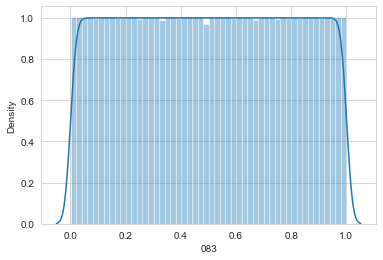

In [373]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

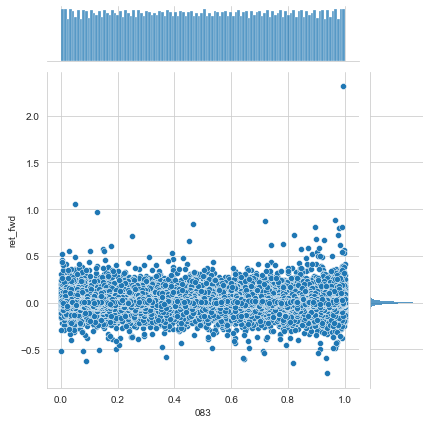

In [374]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [375]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.003762847408203207

In [376]:
# Alpha 084 = power(ts_rank((vwap - ts_max(vwap, 15.3217)), 20.7127), ts_delta(close,4.96796))
def alpha084(c, vwap):
    """ power(ts_rank((vwap - ts_max(vwap, 15.3217)), 20.7127), ts_delta(close,4.96796)) """
    return (rank(power(ts_rank(vwap.sub(ts_max(vwap, 15)), 20), ts_delta(c, 6))).stack('ticker').swaplevel())

In [377]:
%%time
alpha = 84
alphas[f'{alpha:03}'] = alpha084(c, vwap)

CPU times: total: 3min 50s
Wall time: 3min 52s


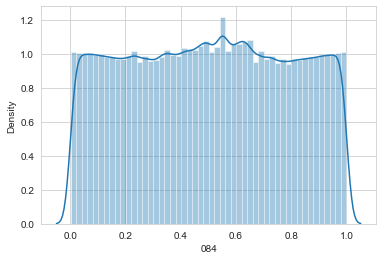

In [378]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

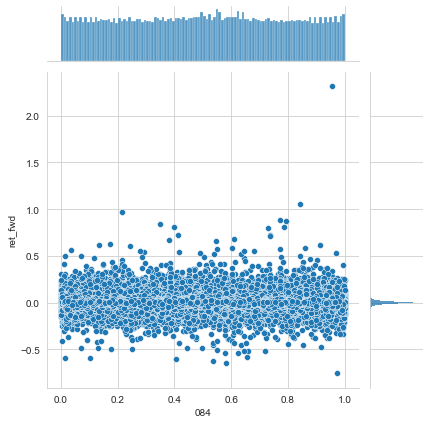

In [379]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [380]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0030345772843283214

In [381]:
# Alpha 085 = power(rank(ts_corr(((high * 0.876703) + (close * (1 - 0.876703))), adv30,9.61331)), rank(ts_corr(ts_rank(((high + low) / 2), 3.70596), ts_rank(volume, 10.1595),7.11408)))
def alpha085(l, v):
    """ power(rank(ts_corr(((high * 0.876703) + (close * (1 - 0.876703))), adv30,9.61331)),
        rank(ts_corr(ts_rank(((high + low) / 2), 3.70596), ts_rank(volume, 10.1595),7.11408))) """
    w = 0.876703
    return (rank(ts_corr(h.mul(w).add(c.mul(1 - w)), ts_mean(v, 30), 10))
            .pow(rank(ts_corr(ts_rank(h.add(l).div(2), 4), ts_rank(v, 10), 7))).stack('ticker').swaplevel())

In [382]:
%%time
alpha = 85
alphas[f'{alpha:03}'] = alpha085(l, v)

CPU times: total: 7min 42s
Wall time: 7min 46s


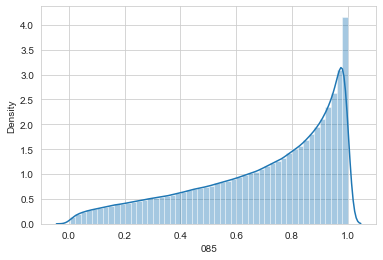

In [383]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

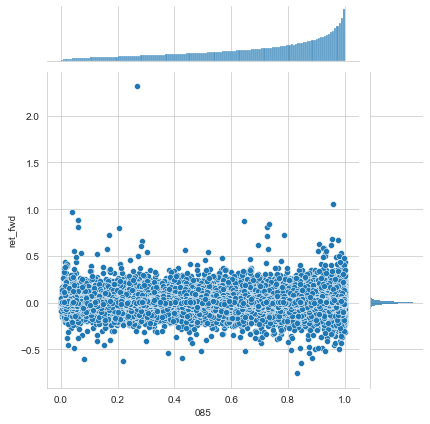

In [384]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [385]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [386]:
# Alpha 086 = ((ts_rank(ts_corr(close, ts_sum(adv20, 14.7444), 6.00049), 20.4195) < rank(((open + close) - (vwap + open)))) * -1)
def alpha086(c, v, vwap):
    """ ((ts_rank(ts_corr(close, ts_sum(adv20, 14.7444), 6.00049), 20.4195) <
        rank(((open + close) - (vwap + open)))) * -1) """
    return (ts_rank(ts_corr(c, ts_mean(ts_mean(v, 20), 15), 6), 20).lt(rank(c.sub(vwap))).mul(-1)
            .stack('ticker').swaplevel())

In [387]:
%%time
alpha = 86
alphas[f'{alpha:03}'] = alpha086(c, v, vwap)

CPU times: total: 3min 48s
Wall time: 3min 50s


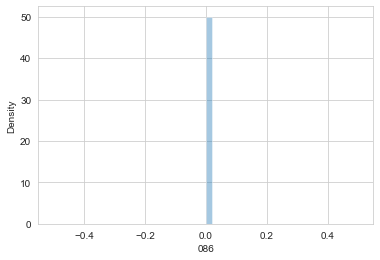

In [388]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

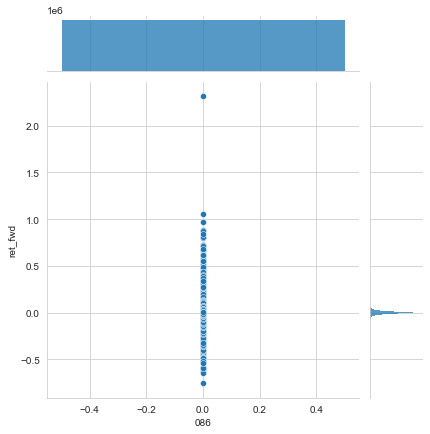

In [389]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [390]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

8.799647150081746e-05

In [ ]:
# Alpha 087 = (max(rank(ts_weighted_mean(ts_delta(((close * 0.369701) + (vwap * (1 - 0.369701))),1.91233), 2.65461)), ts_rank(ts_weighted_mean(abs(ts_corr(IndNeutralize(adv81,IndClass.industry), close, 13.4132)), 4.89768), 14.4535)) * -1)
def alpha087(c, vwap, industry):
    """ (max(rank(ts_weighted_mean(ts_delta(((close * 0.369701) + (vwap * (1 - 0.369701))),1.91233), 2.65461)),
            ts_rank(ts_weighted_mean(abs(ts_corr(IndNeutralize(adv81,IndClass.industry), close, 13.4132)), 4.89768), 14.4535)) * -1) """
    pass

In [391]:
# Alpha 088 = min(rank(ts_weighted_mean(((rank(open) + rank(low)) - (rank(high) + rank(close))),8.06882)), ts_rank(ts_weighted_mean(ts_corr(ts_rank(close, 8.44728), ts_rank(adv60,20.6966), 8.01266), 6.65053), 2.61957))
def alpha088(o, h, l, c, v):
    """ min(rank(ts_weighted_mean(((rank(open) + rank(low)) - (rank(high) + rank(close))),8.06882)),
        ts_rank(ts_weighted_mean(ts_corr(ts_rank(close, 8.44728),
                ts_rank(adv60,20.6966), 8.01266), 6.65053), 2.61957)) """
    s1 = (rank(ts_weighted_mean(rank(o).add(rank(l)).sub(rank(h)).add(rank(c)), 8)))
    s2 = ts_rank(ts_weighted_mean(ts_corr(ts_rank(c, 8), ts_rank(ts_mean(v, 60), 20), 8), 6), 2)

    return (s1.where(s1 < s2, s2).stack('ticker').swaplevel())

In [392]:
%%time
alpha = 88
alphas[f'{alpha:03}'] = alpha088(o, h, l, c, v)

CPU times: total: 7min 38s
Wall time: 7min 41s


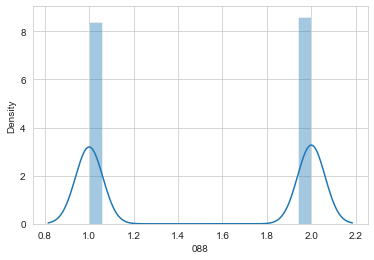

In [393]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

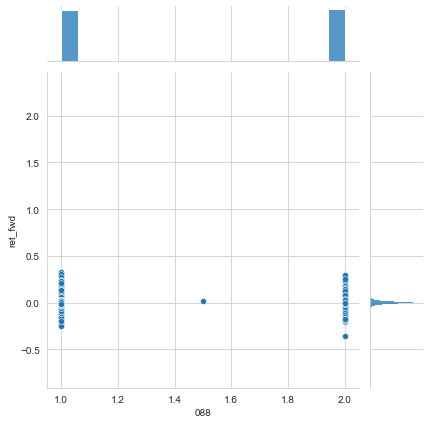

In [394]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [395]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'], n=30000)
mi[alpha]

0

In [ ]:
# Alpha 089 = -rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * rank((returns * cap))
def alpha089(l, v, vwap, industry):
    """ (ts_rank(ts_weighted_mean(ts_corr(((low * 0.967285) +
        (low * (1 - 0.967285))), adv10,6.94279), 5.51607), 3.79744) -
        ts_rank(ts_weighted_mean(ts_delta(IndNeutralize(vwap,IndClass.industry), 3.48158), 10.1466), 15.3012))
    """
    pass

In [ ]:
# Alpha 090 = -rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * rank((returns * cap))
def alpha090(c, l, subindustry):
    """ ((rank((close - ts_max(close, 4.66719)))
        ^ts_rank(ts_corr(IndNeutralize(adv40,IndClass.subindustry), low, 5.38375), 3.21856)) * -1) """
    pass

In [ ]:
# Alpha 091 = ((ts_rank(ts_weighted_mean(ts_weighted_mean(ts_corr(IndNeutralize(close,IndClass.industry), volume, 9.74928), 16.398), 3.83219), 4.8667) - rank(ts_weighted_mean(ts_corr(vwap, adv30, 4.01303), 2.6809))) * -1)
def alpha091(v, vwap, industry):
    """ ((ts_rank(ts_weighted_mean(ts_weighted_mean(ts_corr(IndNeutralize(close,IndClass.industry), volume, 9.74928), 16.398), 3.83219), 4.8667) -
        rank(ts_weighted_mean(ts_corr(vwap, adv30, 4.01303), 2.6809))) * -1) """
    pass

In [433]:
# Alpha 092 = min(ts_rank(ts_weighted_mean(((((high + low) / 2) + close) < (low + open)), 14.7221),18.8683), ts_rank(ts_weighted_mean(ts_corr(rank(low), rank(adv30), 7.58555), 6.94024),6.80584))
def alpha092(o, l, c, v):
    """ min(ts_rank(ts_weighted_mean(((((high + low) / 2) + close) < (low + open)), 14.7221),18.8683),
            ts_rank(ts_weighted_mean(ts_corr(rank(low), rank(adv30), 7.58555), 6.94024),6.80584)) """
    p1 = ts_rank(ts_weighted_mean(h.add(l).div(2).add(c).lt(l.add(o)), 15), 18)
    p2 = ts_rank(ts_weighted_mean(ts_corr(rank(l), rank(ts_mean(v, 30)), 7), 6), 6)

    return (p1.where(p1 < p2, p2).stack('ticker').swaplevel())

In [434]:
%%time
alpha = 92
alphas[f'{alpha:03}'] = alpha092(o, l, c, v)

CPU times: total: 6min 17s
Wall time: 6min 29s
CPU times: total: 6min 3s
Wall time: 6min 13s


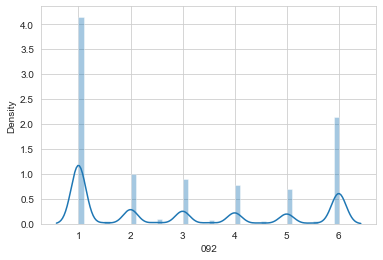

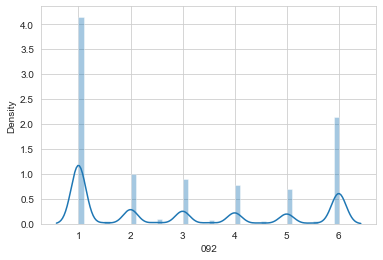

In [435]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

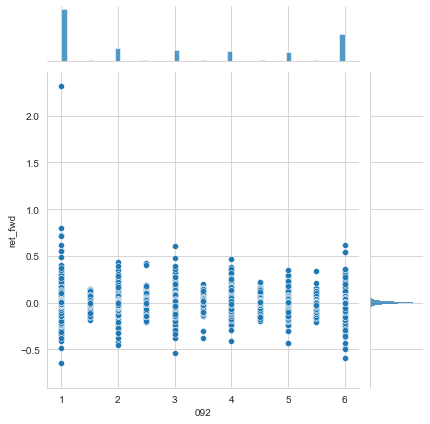

ValueError: Could not interpret value `ret_fwd` for parameter `y`

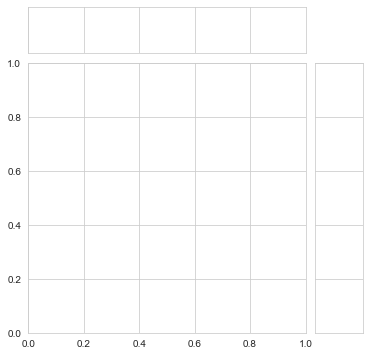

In [436]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.002764910334308368

In [ ]:
# Alpha 093 = (ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(vwap, IndClass.industry), adv81,17.4193), 19.848), 7.54455) / rank(ts_weighted_mean(ts_delta(((close * 0.524434) + (vwap * (1 -0.524434))), 2.77377), 16.2664)))
def alpha093(c, v, vwap, industry):
    """ (ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(vwap, IndClass.industry), adv81,17.4193), 19.848), 7.54455) /
        rank(ts_weighted_mean(ts_delta(((close * 0.524434) + (vwap * (1 -0.524434))), 2.77377), 16.2664)))
    """
    pass

In [ ]:
# Alpha 094 = ((rank((vwap - ts_min(vwap, 11.5783)))^ts_rank(ts_corr(ts_rank(vwap,19.6462), ts_rank(adv60, 4.02992), 18.0926), 2.70756)) * -1)
def alpha094(v, vwap):
    """ ((rank((vwap - ts_min(vwap, 11.5783)))^ts_rank(ts_corr(ts_rank(vwap,19.6462),
        ts_rank(adv60, 4.02992), 18.0926), 2.70756)) * -1) """
    return (rank(vwap.sub(ts_min(vwap, 11)))
            .pow(ts_rank(ts_corr(ts_rank(vwap, 20), ts_rank(ts_mean(v, 60), 4), 18), 2)).mul(-1)
            .stack('ticker').swaplevel())

In [ ]:
%%time
alpha = 94
alphas[f'{alpha:03}'] = alpha094(v, vwap)

CPU times: total: 12min 18s
Wall time: 12min 34s


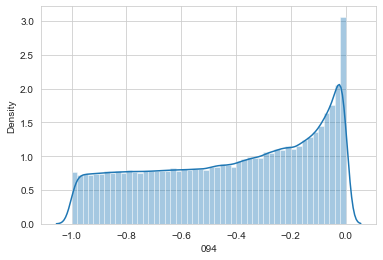

In [ ]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

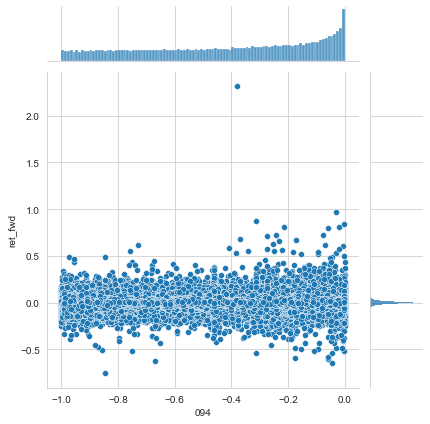

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

In [ ]:
# Alpha 095 = (rank((open - ts_min(open, 12.4105))) < ts_rank((rank(ts_corr(ts_sum(((high + low)/ 2), 19.1351), ts_sum(adv40, 19.1351), 12.8742))^5), 11.7584))
def alpha095(o, l, v):
    """ (rank((open - ts_min(open, 12.4105))) <
        ts_rank((rank(ts_corr(ts_sum(((high + low)/ 2), 19.1351), ts_sum(adv40, 19.1351), 12.8742))^5), 11.7584)) """

    return (rank(o.sub(ts_min(o, 12)))
            .lt(ts_rank(rank(ts_corr(ts_mean(h.add(l).div(2), 19),
                                     ts_sum(ts_mean(v, 40), 19), 13).pow(5)), 12)).astype(int)
            .stack('ticker').swaplevel())

In [ ]:
%%time
alpha = 95
alphas[f'{alpha:03}'] = alpha095(o, l, v)

CPU times: total: 4min 9s
Wall time: 4min 14s


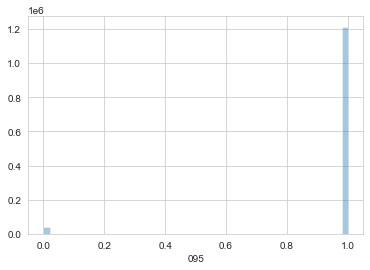

In [ ]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}'], kde=False);

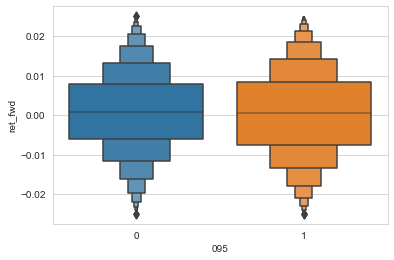

In [ ]:
g = sns.boxenplot(x=f'{alpha:03}', y='ret_fwd', data=alphas[alphas.ret_fwd.between(-.025, .025)]);

In [ ]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
095                                                                          
0      42212.0  0.001107  0.018945 -0.441048 -0.006959  0.000900  0.008912   
1    1212881.0  0.000563  0.025963 -0.757755 -0.009764  0.000481  0.010736   

          max  
095            
0    0.500000  
1    2.317073

In [ ]:
# Alpha 096 = (max(ts_rank(ts_weighted_mean(ts_corr(rank(vwap), rank(volume), 5.83878),4.16783), 8.38151), ts_rank(ts_weighted_mean(ts_argmax(ts_corr(ts_rank(close, 7.45404), ts_rank(adv60, 4.13242), 3.65459), 12.6556), 14.0365), 13.4143)) * -1)
def alpha096(c, v, vwap):
    """ (max(ts_rank(ts_weighted_mean(ts_corr(rank(vwap), rank(volume), 5.83878),4.16783), 8.38151),
        ts_rank(ts_weighted_mean(ts_argmax(ts_corr(ts_rank(close, 7.45404), ts_rank(adv60, 4.13242), 3.65459), 12.6556), 14.0365), 13.4143)) * -1) """

    s1 = ts_rank(ts_weighted_mean(ts_corr(rank(vwap), rank(v), 10), 4), 8)
    s2 = ts_rank(ts_weighted_mean(ts_argmax(ts_corr(ts_rank(c, 7),
                                                    ts_rank(ts_mean(v, 60), 10), 10), 12), 14), 13)
    return (s1.where(s1 > s2, s2).mul(-1).stack('ticker').swaplevel())

In [ ]:
%%time
alpha = 96
alphas[f'{alpha:03}'] = alpha096(c, v, vwap)

CPU times: total: 13min 49s
Wall time: 14min 6s


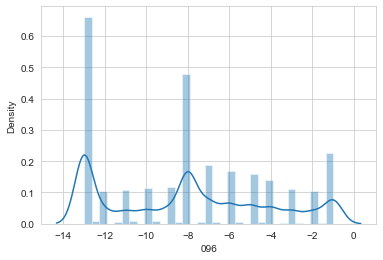

In [ ]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

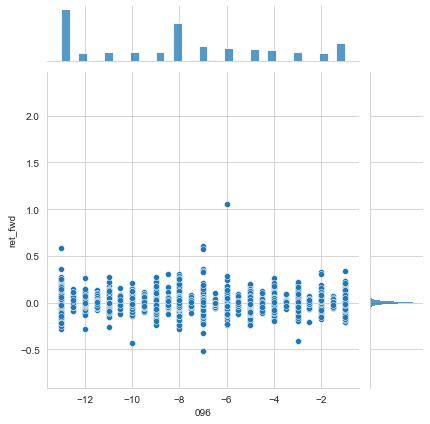

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas)

In [ ]:
# Alpha 097 = -rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * rank((returns * cap))
def alpha097(l):
    """ ((rank(ts_weighted_mean(ts_delta(IndNeutralize(((low * 0.721001) +
        (vwap * (1 - 0.721001))),IndClass.industry), 3.3705), 20.4523)) -
        ts_rank(ts_weighted_mean(ts_rank(ts_corr(Ts_Rank(low,7.87871),
        ts_rank(adv60, 17.255), 4.97547), 18.5925), 15.7152), 6.71659)) * -1) """
    pass

In [415]:
# Alpha 098 = (rank(ts_weighted_mean(ts_corr(vwap, ts_sum(adv5, 26.4719), 4.58418), 7.18088)) - rank(ts_weighted_mean(ts_tank(ts_argmin(ts_corr(rank(open), rank(adv15), 20.8187), 8.62571),6.95668), 8.07206)))
def alpha098(o, v, vwap):
    """ (rank(ts_weighted_mean(ts_corr(vwap, ts_sum(adv5, 26.4719), 4.58418), 7.18088)) -
        rank(ts_weighted_mean(ts_tank(ts_argmin(ts_corr(rank(open),
        rank(adv15), 20.8187), 8.62571),6.95668), 8.07206))) """
    adv5 = ts_mean(v, 5)
    adv15 = ts_mean(v, 15)
    return (rank(ts_weighted_mean(ts_corr(vwap, ts_mean(adv5, 26), 4), 7))
            .sub(rank(ts_weighted_mean(ts_rank(ts_argmin(ts_corr(rank(o), rank(adv15), 20), 8), 6))))
            .stack('ticker').swaplevel())

In [416]:
%%time
alpha = 98
alphas[f'{alpha:03}'] = alpha098(o, v, vwap)

CPU times: total: 6min 40s
Wall time: 6min 47s


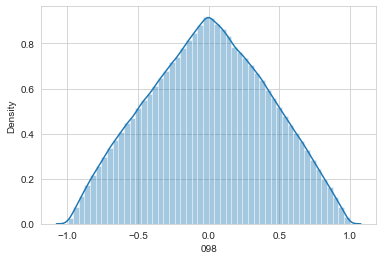

In [417]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

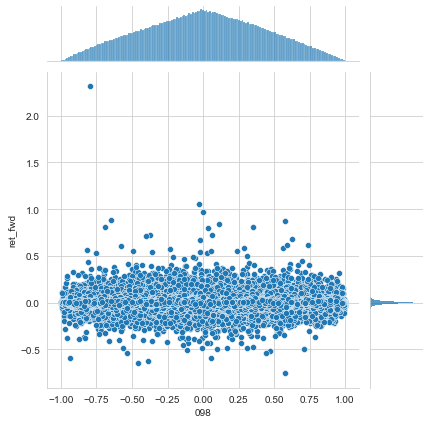

In [418]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [419]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.004411193602617658

In [420]:
# Alpha 099 = ((rank(ts_corr(ts_sum(((high + low) / 2), 19.8975), ts_sum(adv60, 19.8975), 8.8136)) < rank(ts_corr(low, volume, 6.28259))) * -1)
def alpha099(l, v):
    """ ((rank(ts_corr(ts_sum(((high + low) / 2), 19.8975),
                    ts_sum(adv60, 19.8975), 8.8136)) < rank(ts_corr(low, volume, 6.28259))) * -1) """
    return ((rank(ts_corr(ts_sum((h.add(l).div(2)), 19), ts_sum(ts_mean(v, 60), 19), 8))
             .lt(rank(ts_corr(l, v, 6))).mul(-1)).stack('ticker').swaplevel())

In [421]:
%%time
alpha = 99
alphas[f'{alpha:03}'] = alpha099(l, v)

CPU times: total: 5.94 s
Wall time: 5.93 s


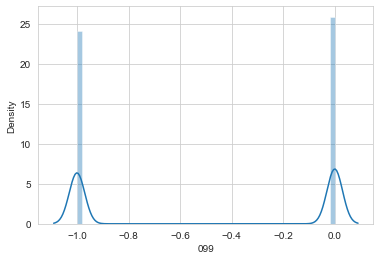

In [422]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

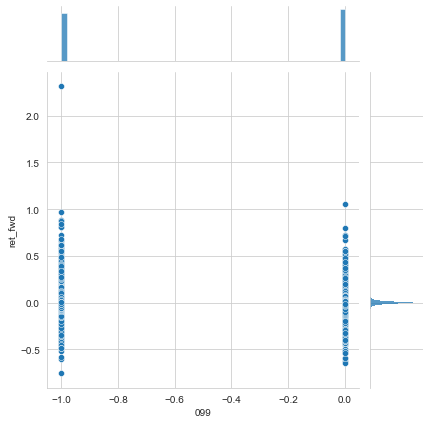

In [423]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [424]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
099                                                                         
-1   604583.0  0.000537  0.026239 -0.757755 -0.009783  0.000448  0.010714   
 0   650510.0  0.000622  0.025303 -0.643066 -0.009524  0.000547  0.010625   

          max  
099            
-1   2.317073  
 0   1.061026

In [425]:
# Alpha 100 = -rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * rank((returns * cap))
def alpha100(r, cap):
    """ (0 - (1 * (((1.5 * scale(indneutralize(
                indneutralize(rank(((((close - low) - (high -close)) / (high - low)) * volume)),
                                IndClass.subindustry), IndClass.subindustry))) -
    scale(indneutralize((ts_corr(close, rank(adv20), 5) - rank(ts_argmin(close, 30))), IndClass.subindustry))) * (volume / adv20)))) """
    pass

In [426]:
# Alpha 101 = -ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
def alpha101(o, h, l, c):
    """((close - open) / ((high - low) + .001))"""
    return (c.sub(o).div(h.sub(l).add(1e-3)).stack('ticker').swaplevel())

In [427]:
%%time
alpha = 101
alphas[f'{alpha:03}'] = alpha101(o, h, l, c)

CPU times: total: 2.03 s
Wall time: 2.03 s


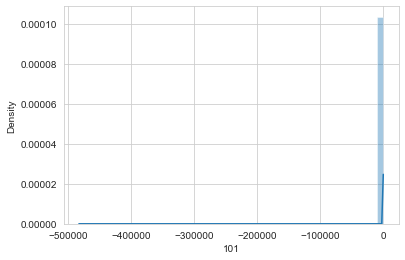

In [428]:
alphas[f'{alpha:03}'].to_hdf('data/alphas.h5', f'alphas/{alpha:03}')
sns.distplot(alphas[f'{alpha:03}']);

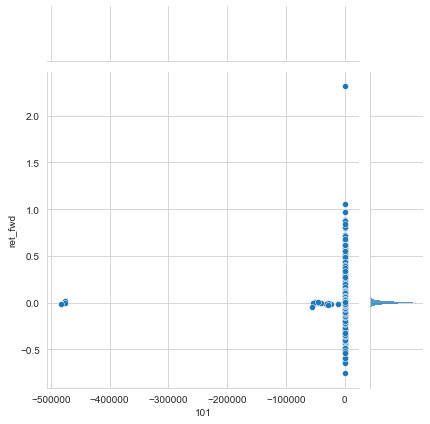

In [429]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [430]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.05150214909562534

In [431]:
# Store results
alphas = []
with pd.HDFStore('data/alphas.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        i = int(key.split('/')[-1])
        alphas.append(store[key].to_frame(i))
alphas = pd.concat(alphas, axis=1)
alphas.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1255093 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-29 00:00:00'))
Data columns (total 82 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   1       1243848 non-null  float64
 1   2       1243080 non-null  float64
 2   3       1227126 non-null  float64
 3   4       1250757 non-null  float64
 4   5       1247732 non-null  float64
 5   6       1250204 non-null  float64
 6   7       1241633 non-null  float64
 7   8       1247172 non-null  float64
 8   9       1247546 non-null  float64
 9   10      1247546 non-null  float64
 10  11      1245754 non-null  float64
 11  12      1247546 non-null  float64
 12  13      1243848 non-null  float64
 13  14      1250204 non-null  float64
 14  15      1048657 non-null  float64
 15  16      1252899 non-null  float64
 16  17      1240819 non-null  float64
 17  18      1240862 non-null  float64
 18  19      1127248 non-null  flo

In [ ]:
alphas.describe()

In [ ]:
alphas.sample(10).sort_values(by='date')

In [432]:
alphas.to_hdf('data/data_alpha_factor.h5', 'factors/formulaic')